# Why relational learning matters

The main purpose of this notebook is to demonstrate how powerful **relational learning** can be.

Relational learning is one of the most **underappreciated fields of machine learning**. Even though relational learning is very **relevant to many real world data science projects**, many data scientists don't even know what relational learning is. 

There are many subdomains of relational learning, but the most important one is **extracting features from relational data**: Most business data is **relational**, meaning that it is spread out over **several relational tables**. However, most machine learning algorithms require that the data be presented in the form of a single flat table. So we need to extract features from our relational data. Some people also call this **data wrangling**.

Most data scientists we know extract features from relational data manually or by using crude, brute-force approaches (randomly generate thousands of features and then do a feature selection). This is very time-consuming and does not produce good features.

This example demonstrates how powerful a real relational learning algorithm can be. Based on a public-domain dataset on consumer behavior, we use a **relational boosting algorithm** to predict whether purchases were **made as a gift**. We show that with relational learning, we can get an **AUC of over 90%**. The generated features would have been **impossible to build by hand** or by using brute-force approaches.

This notebook is **self-contained**. You can just run it to reproduce our results. You will need **getML** in order to do so.
You can **download it for free**:

https://getml.com/product

If you want to learn more, about getML, check out the **official documentation**:

https://docs.getml.com/latest/index.html

## The challenge

The **Consumer Expenditure Data Set** is a public domain data set provided by the American Bureau of Labor Statistics (https://www.bls.gov/cex/pumd.htm). It includes the **diary entries**, where American consumers are asked to keep diaries of the products they have purchased each month.

These consumer goods are categorized using a **six-digit classification system** the **UCC**. This system is hierarchical, meaning that **every digit represents an increasingly granular category**.

For instance, all UCC codes beginning with **‘200’ represent beverages**. UCC codes beginning with **‘20011’ represents beer** and **‘200111’ represents ‘beer and ale’** and ‘200112’ represents ‘nonalcoholic beer’ (https://www.bls.gov/cex/pumd/ce_pumd_interview_diary_dictionary.xlsx).

The diaries also contain a flag that indicates whether the product was purchased as a gift. The challenge is to predict that flag using other information in the diary entries.

This can be done based on the following considerations:

1. Some items are **less likely to be purchased as gifts** than others (for instance, it is unlikely that toilet paper is ever purchased as a gift).

2. Items that diverge from the **usual consumption patterns** are more likely to be gifts.

In total, there are three tables which we find interesting:

1. EXPD, which contains information on the **consumer expenditures**, including the target variable GIFT.

2. FMLD, which contains socio-demographic information on the **households**.

3. MEMD, which contains socio-demographic information on each **member of the households**.


In [1]:
import datetime
import os
from urllib import request
import time
import zipfile

import matplotlib.pyplot as plt
%matplotlib inline

import getml
from getml import data 
from getml import engine 
from getml import feature_learning 
from getml import hyperopt
from getml.feature_learning import loss_functions
from getml.pipeline import Pipeline
from getml.data import placeholder
from getml.data import roles 
from getml.pipeline import scores
from getml import predictors

## Getting the data

First, we need to **download and unzip** the data. For your convenience, we have scripted this.

If you want to download them manually, you can use this link: https://www.bls.gov/cex/pumd.htm.

We will use the diary CSV files for the year 2015. There are more years you can use, but we will limit ourselves to this one year for now.

In [2]:
fname = "diary15.zip"

if not os.path.exists(fname):
    fname, res = request.urlretrieve(
        "https://www.bls.gov/cex/pumd/data/comma/diary15.zip", 
        "diary15.zip"
    )

RAW_DATA_FOLDER = "diary15/"

if not os.path.exists(RAW_DATA_FOLDER):
    with zipfile.ZipFile(fname, 'r') as dzip: 
        dzip.extractall() 

We now set the project.

In getML, every data frame and model is **tied to a project**. If you change the project, then the memory is flushed and all unsaved changes are lost (but don't worry, models are saved automatically).

In [3]:
engine.set_project("consumer-expenditure-notebook")

Creating new project 'consumer-expenditure-notebook'


## Loading the data

We load the data directly into getML data frames. There are other ways to do this, such as using pandas or loading the data into a data base first. But we will us this approach.

In [4]:
# -----------------------------------------------------------------------------
# Load EXPD

expd_fnames = [
    RAW_DATA_FOLDER + "expd151.csv",
    RAW_DATA_FOLDER + "expd152.csv",
    RAW_DATA_FOLDER + "expd153.csv",
    RAW_DATA_FOLDER + "expd154.csv"
]

# The sniffer will interpret NEWID and UCC
# as a numeric column. But we want it
# to be treated as a string.
expd_roles = {"unused_string": ["UCC", "NEWID"]}

df_expd = data.DataFrame.from_csv(
    fnames=expd_fnames,
    name="EXPD",
    roles=expd_roles
)

df_expd

Name,ALLOC,COST,GIFT,PUB_FLAG,EXPNSQDY,EXPN_QDY,EXPNWKDY,EXPN_KDY,EXPNMO,EXPNMO_,EXPNYR,EXPNYR_,UCC,NEWID
Role,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,0,3.89,2,2,4,D,1,D,01,D,2015,D,010210,03111041
1,1,4.37725,2,2,4,D,1,D,01,D,2015,D,060110,03111041
2,1,3.58275,2,2,4,D,1,D,01,D,2015,D,060210,03111041
3,0,5.58,2,2,4,D,1,D,01,D,2015,D,090110,03111041
4,0,1.99,2,2,4,D,1,D,01,D,2015,D,090210,03111041
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412623,0,4.99,2,2,4,D,7,D,12,D,2015,D,550210,03324162
412624,1,11.6549,2,1,3,D,6,D,12,D,2015,D,590230,03324162
412625,1,7.99,2,2,3,D,6,D,12,D,2015,D,660000,03324162


In [5]:
# -----------------------------------------------------------------------------
# Load FMLD

fmld_fnames = [
    RAW_DATA_FOLDER + "fmld151.csv",
    RAW_DATA_FOLDER + "fmld152.csv",
    RAW_DATA_FOLDER + "fmld153.csv",
    RAW_DATA_FOLDER + "fmld154.csv"
]

# The sniffer will interpret NEWID
# as a numeric column. But we want it
# to be treated as a string.
fmld_roles = {"unused_string": ["NEWID"]}

df_fmld = data.DataFrame.from_csv(
    fnames=fmld_fnames,
    name="FMLD",
    roles=fmld_roles
)

df_fmld

Name,INC_RNKM,INC_RNK5,INC_RNK4,INC_RNK3,INC_RNK2,INC_RNK1,INC_RANK,AGE_REF,BLS_URBN,CUTENURE,EARNCOMP,EDUC_REF,FAM_SIZE,FAM_TYPE,FGVX,FINCBEFX,FINLWT21,FIRAX,FJSSDEDX,FPVTX,FRRX,FSS_RRX,FSUPPX,FWAGEX,JFS_AMT,MARITAL1,NO_EARNR,OTHRECX,PERSLT18,PERSOT64,POPSIZE,REF_RACE,SEX_REF,SMSASTAT,STRTMNTH,STRTYEAR,WEEKI,WEEKN,WK_WRKD1,FOODTOT,FOODHOME,CEREAL,BAKEPROD,BEEF,PORK,OTHMEAT,POULTRY,SEAFOOD,EGGS,MILKPROD,OTHDAIRY,FRSHFRUT,FRSHVEG,PROCFRUT,PROCVEG,SWEETS,NONALBEV,OILS,MISCFOOD,FOODAWAY,ALCBEV,SMOKSUPP,PET_FOOD,PERSPROD,PERSSERV,DRUGSUPP,HOUSKEEP,HH_CU_Q,CHILDAGE,INCLASS,CUID,FGVXM,FINCBEFM,FINCBEF1,FINCBEF2,FINCBEF3,FINCBEF4,FINCBEF5,FINCBEFI,FJSSDEDM,FJSSDED1,FJSSDED2,FJSSDED3,FJSSDED4,FJSSDED5,FPVTXM,FRRXM,FS_AMTXI,FSS_RRXM,FSS_RRX1,FSS_RRX2,FSS_RRX3,FSS_RRX4,FSS_RRX5,FSS_RRXI,FSUPPXM,FSUPPX1,FSUPPX2,FSUPPX3,FSUPPX4,FSUPPX5,FSUPPXI,FWAGEXM,FWAGEX1,FWAGEX2,FWAGEX3,FWAGEX4,FWAGEX5,FWAGEXI,JFS_AMTM,JFS_AMT1,JFS_AMT2,JFS_AMT3,JFS_AMT4,JFS_AMT5,OTHINXI,WELFRXI,PICKCODE,HIGH_EDU,FSMPFRMX,FSMPFRX1,FSMPFRX2,FSMPFRX3,FSMPFRX4,FSMPFRX5,FSMPFRXI,FSMPFRXM,INTRDVXI,NETRENTI,OTHREGXI,RETSURVI,ROYESTXI,HISP_REF,AGE_REF_,AGE2,AGE2_,CUTE_URE,DESCRIP,DESCRIP_,EARN_OMP,EDUC0REF,EDUCA2,EDUCA2_,EMPLTYP1,EMPL_YP1,EMPLTYP2,EMPL_YP2,FAM__IZE,FAM__YPE,FGVX_,FINC_EFX,FIRAX_,FJSS_EDX,FPVTX_,FREEMLX,FREEMLX_,FRRX_,FS_MTHI,FS_MTHI_,FSS_RRX_,FSUPPX_,FWAGEX_,HRSPRWK1,HRSP_WK1,HRSPRWK2,HRSP_WK2,JFS_AMT_,JGRCFDMV,JGRC_DMV,JGRCFDWK,JGRC_DWK,JGROCYMV,JGRO_YMV,JGROCYWK,JGRO_YWK,LUMPX,LUMPX_,MARI_AL1,NO_E_RNR,OCCEXPNX,OCCE_PNX,OCCULIS2,OCCU_IS2,OTHINX,OTHINX_,OTHRECX_,PERS_T18,PERS_T64,OCCULIS1,OCCU_IS1,RACE2,RACE2_,REC_FS,REC_FS_,REF__ACE,REGION,SEX_REF_,SEX2,SEX2_,TYPOWND,TYPOWND_,VEHQ,VEHQ_,WEEKI_,WELFRX,WELFRX_,WHYNWRK1,WHYN_RK1,WHYNWRK2,WHYN_RK2,WK_W_KD1,WK_WRKD2,WK_W_KD2,WTREP01,WTREP02,WTREP03,WTREP04,WTREP05,WTREP06,WTREP07,WTREP08,WTREP09,WTREP10,WTREP11,WTREP12,WTREP13,WTREP14,WTREP15,WTREP16,WTREP17,WTREP18,WTREP19,WTREP20,WTREP21,WTREP22,WTREP23,WTREP24,WTREP25,WTREP26,WTREP27,WTREP28,WTREP29,WTREP30,WTREP31,WTREP32,WTREP33,WTREP34,WTREP35,WTREP36,WTREP37,WTREP38,WTREP39,WTREP40,WTREP41,WTREP42,WTREP43,WTREP44,HH_CU_Q_,HHID,HHID_,CHIL_AGE,STATE,INC__ANK,HORREF1,HORREF1_,HORREF2,HORREF2_,FGVXM_,FINC_EFM,FJSS_EDM,FPVTXM_,FRRXM_,FS_AMTXM,FS_A_TXM,FS_AMTX1,FS_AMTX2,FS_AMTX3,FS_AMTX4,FS_AMTX5,FSS__RXM,FSUPPXM_,FWAGEXM_,INC__NKM,JFS__MTM,OTHINXM,OTHINXM_,OTHINX1,OTHINX2,OTHINX3,OTHINX4,OTHINX5,WELFRXM,WELFRXM_,WELFRX1,WELFRX2,WELFRX3,WELFRX4,WELFRX5,LUMPB,LUMPB_,LUMPBX,LUMPBX_,OTHINB,OTHINB_,OTHINBX,OTHINBX_,WELFRB,WELFRB_,WELFRBX,WELFRBX_,PSU,EITC,EITC_,FSMP_RMX,INTRDVB,INTRDVB_,INTRDVBX,INTR_VBX,INTRDVX,INTRDVX_,INTRDVX1,INTRDVX2,INTRDVX3,INTRDVX4,INTRDVX5,INTRDVXM,NETRENTB,NETR_NTB,NETRENTX,NETR_NTX,NETRNTBX,NETR_TBX,NETRENT1,NETRENT2,NETRENT3,NETRENT4,NETRENT5,NETRENTM,OTHREGB,OTHREGB_,OTHREGBX,OTHR_GBX,OTHREGX,OTHREGX_,OTHREGX1,OTHREGX2,OTHREGX3,OTHREGX4,OTHREGX5,OTHREGXM,RETSRVBX,RETS_VBX,RETSURVB,RETS_RVB,RETSURVX,RETS_RVX,RETSURV1,RETSURV2,RETSURV3,RETSURV4,RETSURV5,RETSURVM,ROYESTB,ROYESTB_,ROYESTBX,ROYE_TBX,ROYESTX,ROYESTX_,ROYESTX1,ROYESTX2,ROYESTX3,ROYESTX4,ROYESTX5,ROYESTXM,FSMP_RXM,INTR_VXM,NETR_NTM,OTHR_GXM,RETS_RVM,ROYE_TXM,INT_HOME,INT_PHON,INT__OME,INT__HON,DIVISION,HISP2,NEWID
Role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unus

In [6]:
# -----------------------------------------------------------------------------
# Load MEMD

memd_fnames = [
    RAW_DATA_FOLDER + "memd151.csv",
    RAW_DATA_FOLDER + "memd152.csv",
    RAW_DATA_FOLDER + "memd153.csv",
    RAW_DATA_FOLDER + "memd154.csv"
]

# The sniffer will interpret NEWID
# as a numeric column. But we want it
# to be treated as a string.
memd_roles = {"unused_string": ["NEWID"]}

df_memd = data.DataFrame.from_csv(
    fnames=memd_fnames,
    name="MEMD",
    roles=memd_roles
)

df_memd

Name,MARITAL,MEMBRACE,SEX,AGE,CU_CODE1,MEMBNO,HORIGIN,OCCULIST,HRSPERWK,WKS_WRKD,EMPLTYPE,HISPANIC,WHYNOWRK,HRSP_RWK,WKS__RKD,EMPL_YPE,HISP_NIC,WHYN_WRK,OCCU_IST,AGE_,ANGVX,ANGVX_,ANPVTX,ANPVTX_,ANRRX,ANRRX_,EDUCA,EDUCA_,GROSPAYX,GROS_AYX,GVX,GVX_,IRAX,IRAX_,JSSDEDX,JSSDEDX_,PVTX,PVTX_,RRX,RRX_,SCHLNCHQ,SCHL_CHQ,SCHLNCHX,SCHL_CHX,SLFEMPSS,SLFE_PSS,SS_RRX,SS_RRX_,SUPPX,SUPPX_,US_SUPP,US_SUPP_,WAGEX,WAGEX_,SS_RRQ,SS_RRQ_,SOCRRX,SOCRRX_,ARM_FORC,ARM__ORC,IN_COLL,IN_COLL_,MEDICARE,MEDI_ARE,PAYPERD,PAYPERD_,RC_WHITE,RC_W_ITE,RC_BLACK,RC_B_ACK,RC_NATAM,RC_N_TAM,RC_ASIAN,RC_A_IAN,RC_PACIL,RC_P_CIL,RC_OTHER,RC_O_HER,RC_DK,RC_DK_,ANGVXM,ANGVXM_,ANPVTXM,ANPVTXM_,ANRRXM,ANRRXM_,JSSDEDXM,JSSD_DXM,JSSDEDX1,JSSDEDX2,JSSDEDX3,JSSDEDX4,JSSDEDX5,SLFEMPSM,SLFE_PSM,SLFEMPS1,SLFEMPS2,SLFEMPS3,SLFEMPS4,SLFEMPS5,SOCRRXM,SOCRRXM_,SOCRRX1,SOCRRX2,SOCRRX3,SOCRRX4,SOCRRX5,SS_RRXM,SS_RRXM_,SS_RRX1,SS_RRX2,SS_RRX3,SS_RRX4,SS_RRX5,SS_RRXI,SUPPXM,SUPPXM_,SUPPX1,SUPPX2,SUPPX3,SUPPX4,SUPPX5,SUPPXI,WAGEXM,WAGEXM_,WAGEX1,WAGEX2,WAGEX3,WAGEX4,WAGEX5,WAGEXI,SS_RRB,SS_RRB_,SS_RRBX,SS_RRBX_,SUPPB,SUPPB_,SUPPBX,SUPPBX_,WAGEB,WAGEB_,WAGEBX,WAGEBX_,ASIAN,ASIAN_,OCCUEARN,PAYSTUB,PAYSTUB_,SEMPFRM,SEMPFRM_,SEMPFRMX,SEMP_RMX,SMPFRMB,SMPFRMB_,SMPFRMBX,SMPF_MBX,SEMPFRM1,SEMPFRM2,SEMPFRM3,SEMPFRM4,SEMPFRM5,SEMPFRMI,SEMPFRMM,SEMP_RMM,SOCSRRET,SOCS_RET,WKSTATUS,NEWID
Role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,1,4,1,66,1,1,2,,.,0,,,4,A,D,A,A,D,A,D,.,A,.,A,.,A,1,D,.,A,.,A,.,A,.,A,.,A,.,A,.,A,.,A,.,A,.,A,8400,D,1,D,.,A,.,A,0,D,,A,,A,,A,,A,,A,,A,,A,4,D,,A,,A,,A,.,A,.,A,.,A,.,A,.,.,.,.,.,.,A,.,.,.,.,.,.,A,.,.,.,.,.,.,A,.,.,.,.,.,100,8400,D,8400,8400,8400,8400,8400,100,.,A,.,.,.,.,.,100,,A,.,A,,A,.,A,,A,.,A,7,D,900,,A

When we check out the data frames view in the **getML monitor**, we should now already be able to see the data frames we have just loaded.

![alt text](data-frames-view.png "data frames view")

## Data exploration

The first thing we want to do is to define the target.

Strangely enough, the "GIFT" column we want to predict is encoded into 1 for gift and 2 for no gift. We want to turn that into a binary column.

In [7]:
target = (df_expd["GIFT"] == 1)

df_expd.add(target, "TARGET", roles.target)

We will also turn the "EXPNMO" column into a numerical value (the CSV sniffer has interpreted it as a string, because of missing values).

In [8]:
df_expd.set_role("EXPNMO", roles.numerical)

Now its time for some data exploration. In the getML monitor, we click on "EXPD" in the "Data Frames" table. We then click on the "UCC" header or the little magnifying glass below. We have now reached the column view for UCC.

In the "Settings" card on the bottom right, we can choose to plot the UCC against the TARGET.

![alt text](ucc-vs-target.png "UCC vs TARGET")

These two plots tell us two things:

The "Frequency" plot tells us that the UCC codes are **not evenly distributed**. Some categories of items are purchased far more frequently than others.

The "UCC vs. TARGET" plot tells us that some categories of items are **far more likely to be purchased as gift**. The range is between 60% for some items to 0% for others. In other words, knowing the item's UCC will already get us pretty far towards predicting whether it has been purchased as a gift.

Let's look at something else, which is sort of fun:

![alt text](expnmo-vs-target.png "EXPNMO vs TARGET")

As we mentioned earlier, EXPNMO is the month the expenditure was made. These two plots tell us two things:

The "Frequency" plot tells us that the number of expenditures is **pretty evenly distributed** over the year.

The "EXPNMO vs. TARGET" plot tells us that **purchases made in December are far more likely to be gifts** (almost 5% for December, roughly 2% for all other months).

## Annotating the columns

We now want to annotate the data in EXPD. We have already done so for "EXPNMO" and our target variable, but we want to do the same for other columns as well.

Specifically, we will assign **roles** and **units** to the columns. To learn more about roles and units, check out the **documentation**:

https://docs.getml.com/latest/user_guide/annotating_data/annotating_data.html

### EXPD

In [9]:
# -----------------------------------------------------------------------------
# Make EXPNYR and COST numerical columns

df_expd.set_role(["EXPNYR", "COST"], roles.numerical)

df_expd.set_unit(["EXPNMO"], "month")
df_expd.set_unit(["COST"], "cost")

# -----------------------------------------------------------------------------
# Make newid a join key.

df_expd.set_role("NEWID", roles.join_key)

# -----------------------------------------------------------------------------
# Remove all entries, for which EXPNYR or EXPNYR are nan.

expnyr = df_expd["EXPNYR"]
expnmo = df_expd["EXPNMO"]

not_nan = (expnyr.is_nan() | expnmo.is_nan()).is_false()

df_expd = df_expd.where("EXPD", not_nan)

# -----------------------------------------------------------------------------
# Generate time stamps.

expnyr = df_expd["EXPNYR"]
expnmo = df_expd["EXPNMO"]

ts_strings = expnyr.as_str() + "/" + expnmo.as_str()

df_expd["TIME_STAMP"] = ts_strings.as_ts(["%Y/%n"])

df_expd.set_role("TIME_STAMP", roles.time_stamp)

# -----------------------------------------------------------------------------

df_expd

Name,TIME_STAMP,NEWID,TARGET,EXPNYR,EXPNMO,COST,ALLOC,GIFT,PUB_FLAG,EXPNSQDY,EXPN_QDY,EXPNWKDY,EXPN_KDY,EXPNMO_,EXPNYR_,UCC
Role,time_stamp,join_key,target,numerical,numerical,numerical,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
Unit,"time stamp, comparison only",,,,month,cost,,,,,,,,,,
0,2015-01-01T00:00:00.000000Z,03111041,0,2015,1,3.89,0,2,2,4,D,1,D,D,D,010210
1,2015-01-01T00:00:00.000000Z,03111041,0,2015,1,4.37725,1,2,2,4,D,1,D,D,D,060110
2,2015-01-01T00:00:00.000000Z,03111041,0,2015,1,3.58275,1,2,2,4,D,1,D,D,D,060210
3,2015-01-01T00:00:00.000000Z,03111041,0,2015,1,5.58,0,2,2,4,D,1,D,D,D,090110
4,2015-01-01T00:00:00.000000Z,03111041,0,2015,1,1.99,0,2,2,4,D,1,D,D,D,090210
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398890,2015-12-01T00:00:00.000000Z,03324162,0,2015,12,4.99,0,2,2,4,D,7,D,D,D,550210
398891,2015-12-01T00:00:00.000000Z,03324162,0,2015,12,11.6549,1,2,1,3,D,6,D,D,D,590230


The next part requires some more explanation: As we mentioned earlier, the UCC is based on a **hierarchical system of classification**.

We make use of that fact and create a bunch of substrings. **UCC1** contains only the **first digit**, **UCC2** the **first two digits** and so on. This will also create units with the same name as the column name:

In [10]:
ucc = df_expd["UCC"]

for i in range(5):
    colname = "UCC" + str(i+1)
    df_expd[colname] = ucc.substr(0, i+1)
    df_expd.set_role(colname, roles.categorical)
    df_expd.set_unit(colname, colname)

df_expd.set_role("UCC", roles.categorical)
df_expd.set_unit("UCC", "UCC")

# -----------------------------------------------------------------------------

df_expd

Name,TIME_STAMP,NEWID,TARGET,UCC1,UCC2,UCC3,UCC4,UCC5,UCC,EXPNYR,EXPNMO,COST,ALLOC,GIFT,PUB_FLAG,EXPNSQDY,EXPN_QDY,EXPNWKDY,EXPN_KDY,EXPNMO_,EXPNYR_
Role,time_stamp,join_key,target,categorical,categorical,categorical,categorical,categorical,categorical,numerical,numerical,numerical,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
Unit,"time stamp, comparison only",,,UCC1,UCC2,UCC3,UCC4,UCC5,UCC,,month,cost,,,,,,,,,
0,2015-01-01T00:00:00.000000Z,03111041,0,0,01,010,0102,01021,010210,2015,1,3.89,0,2,2,4,D,1,D,D,D
1,2015-01-01T00:00:00.000000Z,03111041,0,0,06,060,0601,06011,060110,2015,1,4.37725,1,2,2,4,D,1,D,D,D
2,2015-01-01T00:00:00.000000Z,03111041,0,0,06,060,0602,06021,060210,2015,1,3.58275,1,2,2,4,D,1,D,D,D
3,2015-01-01T00:00:00.000000Z,03111041,0,0,09,090,0901,09011,090110,2015,1,5.58,0,2,2,4,D,1,D,D,D
4,2015-01-01T00:00:00.000000Z,03111041,0,0,09,090,0902,09021,090210,2015,1,1.99,0,2,2,4,D,1,D,D,D
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398890,2015-12-01T00:00:00.000000Z,03324162,0,5,55,550,5502,55021,550210,2015,12,4.99,0,2,2,4,D,7,D,D,D
398891,2015-12-01T00:00:00.000000Z,03324162,0,5,59,590,5902,59023,590230,2015,12,11.6549,1,2,1,3,D,6,D,D,D


We're done with EXPD. We can now save our work:

In [11]:
df_expd = df_expd.save()

### MEMD

Next, we annotate the columns in MEMD. MEMD contains information on each member of the household. We just pick a couple of columns we find interesting and assign them the role categorical or numerical.

Also, we need to tell it that NEWID is our join key.

In [12]:
df_memd.set_role([
    "MARITAL",
    "SEX",
    "EMPLTYPE",
    "OCCULIST",
    "WHYNOWRK",
    "EDUCA",
    "MEDICARE",
    "PAYPERD"], roles.categorical)

df_memd.set_role(["AGE", "WAGEX"], roles.numerical)

df_memd.set_role("NEWID", roles.join_key)

df_memd = df_memd.save()

df_memd

Name,NEWID,MARITAL,SEX,EMPLTYPE,OCCULIST,WHYNOWRK,EDUCA,MEDICARE,PAYPERD,AGE,WAGEX,MEMBRACE,CU_CODE1,MEMBNO,HORIGIN,HRSPERWK,WKS_WRKD,HISPANIC,HRSP_RWK,WKS__RKD,EMPL_YPE,HISP_NIC,WHYN_WRK,OCCU_IST,AGE_,ANGVX,ANGVX_,ANPVTX,ANPVTX_,ANRRX,ANRRX_,EDUCA_,GROSPAYX,GROS_AYX,GVX,GVX_,IRAX,IRAX_,JSSDEDX,JSSDEDX_,PVTX,PVTX_,RRX,RRX_,SCHLNCHQ,SCHL_CHQ,SCHLNCHX,SCHL_CHX,SLFEMPSS,SLFE_PSS,SS_RRX,SS_RRX_,SUPPX,SUPPX_,US_SUPP,US_SUPP_,WAGEX_,SS_RRQ,SS_RRQ_,SOCRRX,SOCRRX_,ARM_FORC,ARM__ORC,IN_COLL,IN_COLL_,MEDI_ARE,PAYPERD_,RC_WHITE,RC_W_ITE,RC_BLACK,RC_B_ACK,RC_NATAM,RC_N_TAM,RC_ASIAN,RC_A_IAN,RC_PACIL,RC_P_CIL,RC_OTHER,RC_O_HER,RC_DK,RC_DK_,ANGVXM,ANGVXM_,ANPVTXM,ANPVTXM_,ANRRXM,ANRRXM_,JSSDEDXM,JSSD_DXM,JSSDEDX1,JSSDEDX2,JSSDEDX3,JSSDEDX4,JSSDEDX5,SLFEMPSM,SLFE_PSM,SLFEMPS1,SLFEMPS2,SLFEMPS3,SLFEMPS4,SLFEMPS5,SOCRRXM,SOCRRXM_,SOCRRX1,SOCRRX2,SOCRRX3,SOCRRX4,SOCRRX5,SS_RRXM,SS_RRXM_,SS_RRX1,SS_RRX2,SS_RRX3,SS_RRX4,SS_RRX5,SS_RRXI,SUPPXM,SUPPXM_,SUPPX1,SUPPX2,SUPPX3,SUPPX4,SUPPX5,SUPPXI,WAGEXM,WAGEXM_,WAGEX1,WAGEX2,WAGEX3,WAGEX4,WAGEX5,WAGEXI,SS_RRB,SS_RRB_,SS_RRBX,SS_RRBX_,SUPPB,SUPPB_,SUPPBX,SUPPBX_,WAGEB,WAGEB_,WAGEBX,WAGEBX_,ASIAN,ASIAN_,OCCUEARN,PAYSTUB,PAYSTUB_,SEMPFRM,SEMPFRM_,SEMPFRMX,SEMP_RMX,SMPFRMB,SMPFRMB_,SMPFRMBX,SMPF_MBX,SEMPFRM1,SEMPFRM2,SEMPFRM3,SEMPFRM4,SEMPFRM5,SEMPFRMI,SEMPFRMM,SEMP_RMM,SOCSRRET,SOCS_RET,WKSTATUS
Role,join_key,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,numerical,numerical,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,03111041,1,1,NULL,NULL,4,1,NULL,NULL,66,nan,4,1,1,2,.,0,,A,D,A,A,D,A,D,.,A,.,A,.,A,D,.,A,.,A,.,A,.,A,.,A,.,A,.,A,.,A,.,A,.,A,8400,D,1,D,A,.,A,0,D,,A,,A,A,A,,A,,A,,A,4,D,,A,,A,,A,.,A,.,A,.,A,.,A,.,.,.,.,.,.,A,.,.,.,.,.,.,A,.,.,.,.,.,.,A,.,.,.,.,.,100,8400,D,8400,8400,8400,8400,8400,100,.,A,.,.,.,.,.,100,,A,.,A,,A,.,A,,A,.,A,7,D,900,,

### POPULATION

Our next step is to create the POPULATION table. The POPULATION table defines the statistical population (hence the name) and contains our target variable.

We want to predict whether an expenditure was purchased as a gift, so EXPD is a good starting point. However, there is also the FMLD table. FMLD contains demographic information on the household as whole. Because this information is unique for every household, EXPD and FMLD are in a **many-to-one relationship**. We can therefore **directly join FMLD onto EXPD** and do not have extract any features from FMLD.

To learn more about joining, check out the **official documentation**:

https://docs.getml.com/latest/api/getml.data.DataFrame.html#getml.data.DataFrame.join

In [13]:
# -----------------------------------------------------------------------------
# Separate EXPD in training, testing, validation set

random = df_expd.random()

df_population_training = df_expd.where("POPULATION_TRAINING", random <= 0.7)

df_population_validation = df_expd.where("POPULATION_VALIDATION", (random <= 0.85) & (random > 0.7))

df_population_testing = df_expd.where("POPULATION_TESTING", random > 0.85)

# -----------------------------------------------------------------------------------------------
# NEWID in FMLD is unique - therefore, we can just LEFT JOIN it onto the POPULATION tables. 

income_ranks = [
    "INC_RANK",
    "INC_RNK1",
    "INC_RNK2",
    "INC_RNK3",
    "INC_RNK4",
    "INC_RNK5",
    "INC_RNKM"
]

df_fmld.set_role(income_ranks, roles.numerical)

for inc in income_ranks:
    df_fmld.set_unit(inc, inc)

df_fmld.set_role("NEWID", roles.join_key)

df_population_training = df_population_training.join(
        name="POPULATION_TRAINING", 
        other=df_fmld, 
        join_key="NEWID",
        other_cols=[
            df_fmld["INC_RANK"],
            df_fmld["INC_RNK1"],
            df_fmld["INC_RNK2"],
            df_fmld["INC_RNK3"],
            df_fmld["INC_RNK4"],
            df_fmld["INC_RNK5"],
            df_fmld["INC_RNKM"]
        ]
)

df_population_validation = df_population_validation.join(
        name="POPULATION_VALIDATION", 
        other=df_fmld, 
        join_key="NEWID",
        other_cols=[
            df_fmld["INC_RANK"],
            df_fmld["INC_RNK1"],
            df_fmld["INC_RNK2"],
            df_fmld["INC_RNK3"],
            df_fmld["INC_RNK4"],
            df_fmld["INC_RNK5"],
            df_fmld["INC_RNKM"]
        ]
)

df_population_testing = df_population_testing.join(
        name="POPULATION_TESTING", 
        other=df_fmld, 
        join_key="NEWID",
        other_cols=[
            df_fmld["INC_RANK"],
            df_fmld["INC_RNK1"],
            df_fmld["INC_RNK2"],
            df_fmld["INC_RNK3"],
            df_fmld["INC_RNK4"],
            df_fmld["INC_RNK5"],
            df_fmld["INC_RNKM"]
        ]
)

# -----------------------------------------------------------------------------------------------

df_population_training = df_population_training.save()

df_population_validation = df_population_validation.save()

df_population_testing = df_population_testing.save()

# -----------------------------------------------------------------------------------------------

df_population_training

Name,TIME_STAMP,NEWID,TARGET,UCC1,UCC2,UCC3,UCC4,UCC5,UCC,EXPNYR,EXPNMO,COST,INC_RANK,INC_RNK1,INC_RNK2,INC_RNK3,INC_RNK4,INC_RNK5,INC_RNKM,ALLOC,GIFT,PUB_FLAG,EXPNSQDY,EXPN_QDY,EXPNWKDY,EXPN_KDY,EXPNMO_,EXPNYR_
Role,time_stamp,join_key,target,categorical,categorical,categorical,categorical,categorical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
Unit,"time stamp, comparison only",,,UCC1,UCC2,UCC3,UCC4,UCC5,UCC,,month,cost,INC_RANK,INC_RNK1,INC_RNK2,INC_RNK3,INC_RNK4,INC_RNK5,INC_RNKM,,,,,,,,,
0,2015-01-01T00:00:00.000000Z,03111041,0,0,01,010,0102,01021,010210,2015,1,3.89,0.304403,0.144808,0.142726,0.143244,0.14218,0.138187,0.126976,0,2,2,4,D,1,D,D,D
1,2015-01-01T00:00:00.000000Z,03111041,0,0,06,060,0602,06021,060210,2015,1,3.58275,0.304403,0.144808,0.142726,0.143244,0.14218,0.138187,0.126976,1,2,2,4,D,1,D,D,D
2,2015-01-01T00:00:00.000000Z,03111041,0,1,11,110,1104,11041,110410,2015,1,0.8464,0.304403,0.144808,0.142726,0.143244,0.14218,0.138187,0.126976,1,2,2,4,D,1,D,D,D
3,2015-01-01T00:00:00.000000Z,03111041,0,1,11,110,1105,11051,110510,2015,1,1.1336,0.304403,0.144808,0.142726,0.143244,0.14218,0.138187,0.126976,1,2,2,4,D,1,D,D,D
4,2015-01-01T00:00:00.000000Z,03111041,0,1,12,120,1201,12011,120110,2015,1,2.69,0.304403,0.144808,0.142726,0.143244,0.14218,0.138187,0.126976,0,2,2,4,D,1,D,D,D
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278850,2015-12-01T00:00:00.000000Z,03324162,0,3,38,380,3803,38034,380340,2015,12,21.59,0.395303,0.379146,0.584284,0.282733,0.423049,0.359003,0.408166,0,2,2,3,D,6,D,D,D
278851,2015-12-01T00:00:00.000000Z,03324162,0,5,55,550,5502,55021,550210,2015,12,1.91763,0.395303,0.379146,0.584284,0.282733,0.423049,0.359003,0.408166,1,2,2,4,D,7,D,D,D


## Extracting the features

Enough with the data preparation. Let's get to the fun part: Extracting the features using **relational boosting**.

### Defining the data model

First, we define the data model.

What we want to do is the following: 

1. We want to compare every expenditure made to all **expenditures by the same household** (EXPD).

2. We want to check out whether **certain kinds of items have been purchased as a gift in the past** (EXPD).

2. We want to aggregate all available information on the **individual members of the household** (MEMD).



In [14]:
population_placeholder = placeholder.Placeholder("POPULATION")

expd_placeholder = placeholder.Placeholder("EXPD")

memd_placeholder = placeholder.Placeholder("MEMD")

population_placeholder.join(
    expd_placeholder,
    join_key="NEWID",
    time_stamp="TIME_STAMP"
)

population_placeholder.join(
    expd_placeholder,
    join_key="NEWID",
    time_stamp="TIME_STAMP",
    horizon=getml.data.time.days(1),
    allow_lagged_targets=True
)

population_placeholder.join(
    memd_placeholder,
    join_key="NEWID"
)

### Setting the hyperparameters

We use **xgboost** as our predictor and **relboost** (short for relational boosting) to generate our features. You are free to play with the hyperparameters.

In [15]:
feature_learner = feature_learning.RelboostModel(
    loss_function=loss_functions.CrossEntropyLoss,
    shrinkage=0.1,
    gamma=0.0,
    min_num_samples=200,
    num_features=10,
    reg_lambda=0.0,
    sampling_factor=1.0,
    num_threads=1
)

feature_selector = predictors.XGBoostClassifier(n_jobs=1)

predictor = predictors.XGBoostClassifier(
    booster="gbtree",
    n_estimators=100,
    n_jobs=6,
    max_depth=7,
    reg_lambda=0.0
)

pipeline = Pipeline(
    tags=["relboost only", "first shot"],
    population=population_placeholder,
    peripheral=[expd_placeholder, memd_placeholder],
    share_selected_features=0.9,
    feature_learners=feature_learner,
    feature_selectors=feature_selector,
    predictors=predictor,
    include_categorical=True
)

`.fit(...)` will automatically call `.check(...)`, but it is always a good idea to call `.check(...)` separately, so we still have time for some last-minute fixes.

In [16]:
pipeline.check(
    population_table=df_population_training,
    peripheral_tables={"EXPD": df_expd, "MEMD": df_memd}
)

Checking data model...
OK.


### Fitting the pipeline

OK, let's go:

In [17]:
pipeline.fit(
    population_table=df_population_training,
    peripheral_tables={"EXPD": df_expd, "MEMD": df_memd}
)

Checking data model...
OK.

RelboostModel: Training features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as feature selector...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:7m:45.422153



Pipeline(feature_learners=['RelboostModel'], 
         feature_selectors=['XGBoostClassifier'], include_categorical=True, 
         peripheral=['EXPD', 'MEMD'], population='POPULATION', 
         predictors=['XGBoostClassifier'], 
         tags=['relboost only', 'first shot'], share_selected_features=0.9)

url: /user/getml-getml-demo-7mh0lmxq/proxy/1709/getpipeline/BpfZMa/0/

### Scoring the model

We want to know how well we did. We will to an in-sample and an out-of-sample evaluation:

In [18]:
scores = pipeline.score(
    population_table=df_population_training,
    peripheral_tables={"EXPD": df_expd, "MEMD": df_memd}
)

print("In-sample:")
print(scores)
print()

scores = pipeline.score(
    population_table=df_population_testing,
    peripheral_tables=[df_expd, df_memd]
)

print("Out-of-sample:")
print(scores)
print()


RelboostModel: Building features...
[========================================] 100%

In-sample:
{'accuracy': [0.9844184253465063], 'auc': [0.9536678174725355], 'cross_entropy': [0.05641237978205244]}


RelboostModel: Building features...
[========================================] 100%

Out-of-sample:
{'accuracy': [0.9797556719022688], 'auc': [0.9078092041076423], 'cross_entropy': [0.07001521520661812]}



There you go. We just got an **out-of-sample AUC of about 91%**.

But this is just our first shot. We aren't done until we have conducted a **hyperparameter optimization**.

In [19]:
param_space = {
    "predictors": [
        {
            "max_depth": [7, 15],
            "reg_lambda": [0, 100]
        }
    ]
}

Because we want to speed things up a little, we **only optimize the predictor**. We could optimize the feature learners as well, but this is fine for demonstration purposes.

We will use a `GaussianHyperparameterSearch`, which is a **Bayesian hyperparameter optimization** algorithm with a **Gaussian process** at its core. It will be trained on the training set and validated on the validation set.

In [20]:
gaussian_search = hyperopt.GaussianHyperparameterSearch(
    pipeline=pipeline,
    param_space=param_space,
    n_iter=10,
    score=getml.pipeline.scores.auc,
    ratio_iter=0.6
)

gaussian_search = gaussian_search.fit(  
    population_table_training=df_population_training,
    population_table_validation=df_population_validation,
    peripheral_tables={"EXPD": df_expd, "MEMD": df_memd}
)

Checking data model...
OK.

Burning in using latinHypercube search...
[========================================] 100%

Optimizing using Gaussian process...
[========================================] 100%

Time taken: 0h:37m:32.770339



To ensure a fair comparison with our manual hyperparameters, we evaluate the best pipeline from the hyperparameter optimization on the **testing set** as well:

In [21]:
best_pipeline = gaussian_search.best_pipeline

best_pipeline

Pipeline(feature_learners=['RelboostModel'], 
         feature_selectors=['XGBoostClassifier'], include_categorical=True, 
         peripheral=['EXPD', 'MEMD'], population='POPULATION', 
         predictors=['XGBoostClassifier'], 
         tags=['relboost only', 'first shot', 'hyperopt-UEyr0F'], 
         share_selected_features=0.9)

url: /user/getml-getml-demo-7mh0lmxq/proxy/1709/getpipeline/RXK7at/0/

In [22]:
best_pipeline = gaussian_search.best_pipeline

scores = best_pipeline.score(
    population_table=df_population_training,
    peripheral_tables={"EXPD": df_expd, "MEMD": df_memd}
)

print("In-sample:")
print(scores)
print()

scores = best_pipeline.score(
    population_table=df_population_testing,
    peripheral_tables={"EXPD": df_expd, "MEMD": df_memd}
)

print("Out-of-sample:")
print(scores)
print()


RelboostModel: Building features...
[========================================] 100%

In-sample:
{'accuracy': [0.9876997005612236], 'auc': [0.9769002055872064], 'cross_entropy': [0.04619001333935569]}


RelboostModel: Building features...
[========================================] 100%

Out-of-sample:
{'accuracy': [0.9806365827308235], 'auc': [0.9234797549545668], 'cross_entropy': [0.06552344535051384]}



As we can see, we can **slightly increase our predictive performance** by conducting a hyperparameter optimization - but not by much. `RelboostModel` and `XGBoostClassifier` are both robust models that **do not require a lot of optimization**. The default parameters usually perform well.

## Studying the features

It is very important that we get an idea about the features that the relational boosting algorithm has produced.

In [23]:
best_pipeline.features.to_pandas()

,names,correlations,importances,target,sql
0,feature_1_1,0.237512,0.087224,TARGET,"CREATE TABLE ""FEATURE_1_1"" AS\nSELECT SUM( \n ..."
1,feature_1_2,0.254608,0.189692,TARGET,"CREATE TABLE ""FEATURE_1_2"" AS\nSELECT AVG( \n ..."
2,feature_1_3,0.232585,0.078707,TARGET,"CREATE TABLE ""FEATURE_1_3"" AS\nSELECT AVG( \n ..."
3,feature_1_4,0.211837,0.027959,TARGET,"CREATE TABLE ""FEATURE_1_4"" AS\nSELECT AVG( \n ..."
4,feature_1_5,0.177310,0.048394,TARGET,"CREATE TABLE ""FEATURE_1_5"" AS\nSELECT AVG( \n ..."
5,feature_1_6,0.190062,0.060164,TARGET,"CREATE TABLE ""FEATURE_1_6"" AS\nSELECT AVG( \n ..."
6,feature_1_7,0.170165,0.037439,TARGET,"CREATE TABLE ""FEATURE_1_7"" AS\nSELECT AVG( \n ..."
7,feature_1_8,0.140238,0.040257,TARGET,"CREATE TABLE ""FEATURE_1_8"" AS\nSELECT SUM( \n ..."
8,feature_1_9,0.186245,0.046162,TARGET,"CREATE TABLE ""FEATURE_1_9"" AS\nSELECT AVG( \n ..."
9,feature_1_10,0.126905,0.045884,TARGET,"CREATE TABLE ""FEATURE_1_10"" AS\nSELECT SUM( \n..."


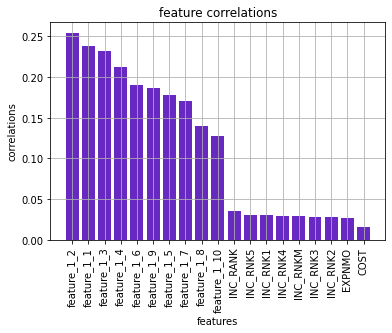

In [24]:
names, correlations = best_pipeline.features.correlations()

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

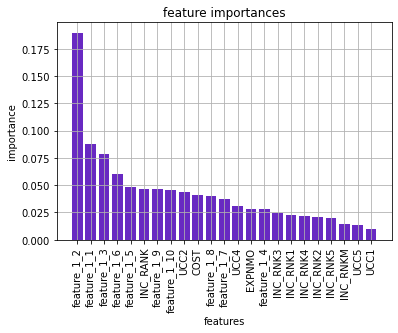

In [25]:
names, importances = best_pipeline.features.importances()

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

The names are already sorted by importance. If we want to get the most important features, we can do this:

In [26]:
best_pipeline.features.to_sql()[names[0]]

```sql
CREATE TABLE "FEATURE_1_2" AS
SELECT AVG( 
    CASE
        WHEN ( t1."UCC3" IN ( '010', '060', '090', '110', '120', '130', '140', '160', '170', '180', '190', '290', '550', '620', '640', '650', '020', '030', '080', '100', '280', '470', '630', '260', '270', '040', '220', '560', '070', '050', '240', '310', '350', '500', '660', '200', '600', '250', '340', '520', '490', '430', '540', '690', '580', '480', '420', '670', '002', '680', '590', '210', '009', '530', '230', '440', '570', '999' ) ) AND ( t1."UCC" IN ( '010210', '060110', '060210', '090110', '090210', '110510', '120110', '120310', '120410', '130212', '130310', '140110', '160211', '180410', '190111', '190211', '550210', '620912', '650210', '020110', '020210', '020620', '020710', '020810', '020820', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '170520', '170532', '180220', '180420', '180510', '180710', '190112', '190113', '470111', '630110', '190313', '260110', '270000', '040310', '120210', '190114', '190212', '190321', '270310', '560110', '070240', '190311', '190322', '260210', '040110', '070230', '100110', '140220', '010320', '050210', '160110', '160310', '170310', '170531', '470211', '140230', '240320', '350110', '500110', '030810', '040210', '040410', '050110', '050310', '060310', '160320', '170410', '180110', '600210', '640210', '190324', '250210', '270210', '310352', '340510', '520531', '550310', '160212', '180611', '180612', '280140', '490312', '540000', '690120', '030410', '130110', '170510', '480213', '490000', '190312', '200512', '200532', '340410', '670310', '002100', '210110', '180210', '010110', '110310', '270410', '030510', '620310', '130211', '200522', '470220', '520541', '250900', '580000', '220000', '620330', '009000', '190314', '130121', '190214', '010310', '560210', '630210', '530412', '620111', '200511', '220120', '230110', '440210', '590110', '140330', '130122', '670902', '030210', '340530', '440120', '550320', '240110', '340210', '200531', '520110', '310220', '180620', '620410', '620810', '030310', '690114', '680220', '050410', '680903', '240120', '230900', '190323', '620420', '530110', '550110', '190213', '620213', '999900', '560400', '290440', '620320', '310232', '310340', '570000', '620510', '630220', '430130', '340310', '600900', '440130', '002000' ) ) AND ( t2."UCC" IN ( '010210', '060110', '060210', '090110', '110410', '110510', '120310', '120410', '140110', '160211', '170110', '180320', '180410', '190211', '550210', '640110', '010120', '020110', '020210', '020620', '020710', '020810', '030110', '030710', '080110', '100510', '110110', '110210', '140420', '180220', '180510', '280120', '330210', '190112', '470111', '630110', '190313', '270000', '040310', '120210', '190114', '190321', '270310', '370213', '560110', '610310', '070240', '140210', '190322', '260210', '070230', '140220', '330310', '010320', '020410', '030610', '050210', '160110', '160310', '170310', '360350', '470211', '020510', '140230', '240320', '400210', '500110', '640310', '040210', '040410', '040510', '050110', '050310', '160320', '170410', '180110', '370125', '380315', '390120', '600210', '170533', '250210', '270210', '310352', '320904', '340510', '370211', '520531', '550310', '340110', '150212', '160212', '180611', '180612', '280140', '490312', '540000', '690120', '320903', '070110', '130110', '320420', '400110', '320345', '190312', '200532', '340410', '390310', '390321', '400220', '420115', '640410', '590230', '210110', '180210', '380340', '640220', '010110', '110310', '270410', '030510', '240210', '620310', '130211', '140340', '320130', '380333', '400310', '200522', '520541', '360311', '360312', '360513', '250900', '190314', '130121', '190214', '370314', '490300', '010310', '530311', '560210', '240310', '630210', '530210', '530412', '620111', '200511', '220120', '230110', '340520', '440210', '590110', '140330', '390210', '390223', '410120', '030210', '340530', '440120', '550320', '620926', '340210', '320232', '380430', '520110', '380410', '310220', '320110', '180620', '620410', '620221', '320221', '550330', '370901', '030310', '680220', '050410', '280110', '680903', '590210', '240120', '190323', '600420', '620420', '530110', '390230', '550110', '190213', '620213', '999900', '560400', '320521', '310232', '570000', '620510', '320150', '630220', '340310' ) ) THEN -1.712197
        WHEN ( t1."UCC3" IN ( '010', '060', '090', '110', '120', '130', '140', '160', '170', '180', '190', '290', '550', '620', '640', '650', '020', '030', '080', '100', '280', '470', '630', '260', '270', '040', '220', '560', '070', '050', '240', '310', '350', '500', '660', '200', '600', '250', '340', '520', '490', '430', '540', '690', '580', '480', '420', '670', '002', '680', '590', '210', '009', '530', '230', '440', '570', '999' ) ) AND ( t1."UCC" IN ( '010210', '060110', '060210', '090110', '090210', '110510', '120110', '120310', '120410', '130212', '130310', '140110', '160211', '180410', '190111', '190211', '550210', '620912', '650210', '020110', '020210', '020620', '020710', '020810', '020820', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '170520', '170532', '180220', '180420', '180510', '180710', '190112', '190113', '470111', '630110', '190313', '260110', '270000', '040310', '120210', '190114', '190212', '190321', '270310', '560110', '070240', '190311', '190322', '260210', '040110', '070230', '100110', '140220', '010320', '050210', '160110', '160310', '170310', '170531', '470211', '140230', '240320', '350110', '500110', '030810', '040210', '040410', '050110', '050310', '060310', '160320', '170410', '180110', '600210', '640210', '190324', '250210', '270210', '310352', '340510', '520531', '550310', '160212', '180611', '180612', '280140', '490312', '540000', '690120', '030410', '130110', '170510', '480213', '490000', '190312', '200512', '200532', '340410', '670310', '002100', '210110', '180210', '010110', '110310', '270410', '030510', '620310', '130211', '200522', '470220', '520541', '250900', '580000', '220000', '620330', '009000', '190314', '130121', '190214', '010310', '560210', '630210', '530412', '620111', '200511', '220120', '230110', '440210', '590110', '140330', '130122', '670902', '030210', '340530', '440120', '550320', '240110', '340210', '200531', '520110', '310220', '180620', '620410', '620810', '030310', '690114', '680220', '050410', '680903', '240120', '230900', '190323', '620420', '530110', '550110', '190213', '620213', '999900', '560400', '290440', '620320', '310232', '310340', '570000', '620510', '630220', '430130', '340310', '600900', '440130', '002000' ) ) AND ( t2."UCC" NOT IN ( '010210', '060110', '060210', '090110', '110410', '110510', '120310', '120410', '140110', '160211', '170110', '180320', '180410', '190211', '550210', '640110', '010120', '020110', '020210', '020620', '020710', '020810', '030110', '030710', '080110', '100510', '110110', '110210', '140420', '180220', '180510', '280120', '330210', '190112', '470111', '630110', '190313', '270000', '040310', '120210', '190114', '190321', '270310', '370213', '560110', '610310', '070240', '140210', '190322', '260210', '070230', '140220', '330310', '010320', '020410', '030610', '050210', '160110', '160310', '170310', '360350', '470211', '020510', '140230', '240320', '400210', '500110', '640310', '040210', '040410', '040510', '050110', '050310', '160320', '170410', '180110', '370125', '380315', '390120', '600210', '170533', '250210', '270210', '310352', '320904', '340510', '370211', '520531', '550310', '340110', '150212', '160212', '180611', '180612', '280140', '490312', '540000', '690120', '320903', '070110', '130110', '320420', '400110', '320345', '190312', '200532', '340410', '390310', '390321', '400220', '420115', '640410', '590230', '210110', '180210', '380340', '640220', '010110', '110310', '270410', '030510', '240210', '620310', '130211', '140340', '320130', '380333', '400310', '200522', '520541', '360311', '360312', '360513', '250900', '190314', '130121', '190214', '370314', '490300', '010310', '530311', '560210', '240310', '630210', '530210', '530412', '620111', '200511', '220120', '230110', '340520', '440210', '590110', '140330', '390210', '390223', '410120', '030210', '340530', '440120', '550320', '620926', '340210', '320232', '380430', '520110', '380410', '310220', '320110', '180620', '620410', '620221', '320221', '550330', '370901', '030310', '680220', '050410', '280110', '680903', '590210', '240120', '190323', '600420', '620420', '530110', '390230', '550110', '190213', '620213', '999900', '560400', '320521', '310232', '570000', '620510', '320150', '630220', '340310' ) ) THEN 0.628627
        WHEN ( t1."UCC3" IN ( '010', '060', '090', '110', '120', '130', '140', '160', '170', '180', '190', '290', '550', '620', '640', '650', '020', '030', '080', '100', '280', '470', '630', '260', '270', '040', '220', '560', '070', '050', '240', '310', '350', '500', '660', '200', '600', '250', '340', '520', '490', '430', '540', '690', '580', '480', '420', '670', '002', '680', '590', '210', '009', '530', '230', '440', '570', '999' ) ) AND ( t1."UCC" NOT IN ( '010210', '060110', '060210', '090110', '090210', '110510', '120110', '120310', '120410', '130212', '130310', '140110', '160211', '180410', '190111', '190211', '550210', '620912', '650210', '020110', '020210', '020620', '020710', '020810', '020820', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '170520', '170532', '180220', '180420', '180510', '180710', '190112', '190113', '470111', '630110', '190313', '260110', '270000', '040310', '120210', '190114', '190212', '190321', '270310', '560110', '070240', '190311', '190322', '260210', '040110', '070230', '100110', '140220', '010320', '050210', '160110', '160310', '170310', '170531', '470211', '140230', '240320', '350110', '500110', '030810', '040210', '040410', '050110', '050310', '060310', '160320', '170410', '180110', '600210', '640210', '190324', '250210', '270210', '310352', '340510', '520531', '550310', '160212', '180611', '180612', '280140', '490312', '540000', '690120', '030410', '130110', '170510', '480213', '490000', '190312', '200512', '200532', '340410', '670310', '002100', '210110', '180210', '010110', '110310', '270410', '030510', '620310', '130211', '200522', '470220', '520541', '250900', '580000', '220000', '620330', '009000', '190314', '130121', '190214', '010310', '560210', '630210', '530412', '620111', '200511', '220120', '230110', '440210', '590110', '140330', '130122', '670902', '030210', '340530', '440120', '550320', '240110', '340210', '200531', '520110', '310220', '180620', '620410', '620810', '030310', '690114', '680220', '050410', '680903', '240120', '230900', '190323', '620420', '530110', '550110', '190213', '620213', '999900', '560400', '290440', '620320', '310232', '310340', '570000', '620510', '630220', '430130', '340310', '600900', '440130', '002000' ) ) AND ( t2."UCC" IN ( '010210', '060110', '060210', '090110', '090210', '110410', '110510', '120110', '120310', '120410', '130212', '130310', '130320', '140110', '160211', '170110', '170210', '180320', '180410', '190111', '320140', '330510', '550210', '620912', '010120', '020110', '020210', '020310', '020610', '020710', '020810', '020820', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '150110', '170520', '170532', '180220', '180420', '180510', '180710', '280120', '330210', '190112', '190113', '330110', '470111', '260110', '270000', '040310', '120210', '270310', '560110', '610310', '070240', '140210', '040110', '070230', '140220', '330310', '010320', '030610', '050210', '160310', '170310', '170531', '180520', '020510', '140230', '320905', '640310', '030810', '040210', '040410', '040510', '050110', '050310', '060310', '160320', '170410', '180110', '640210', '170533', '270210', '520531', '550310', '150310', '160212', '180611', '180612', '430120', '490312', '070110', '150211', '170510', '400110', '480213', '490000', '420115', '640410', '590230', '210110', '180210', '010110', '110310', '030510', '240210', '130211', '140340', '380333', '520541', '360513', '009000', '190314', '620121', '010310', '530311', '240310', '530210', '620111', '390210', '390223', '410120', '330610', '620926', '280110', '320380', '620510' ) ) THEN -2.664393
        WHEN ( t1."UCC3" IN ( '010', '060', '090', '110', '120', '130', '140', '160', '170', '180', '190', '290', '550', '620', '640', '650', '020', '030', '080', '100', '280', '470', '630', '260', '270', '040', '220', '560', '070', '050', '240', '310', '350', '500', '660', '200', '600', '250', '340', '520', '490', '430', '540', '690', '580', '480', '420', '670', '002', '680', '590', '210', '009', '530', '230', '440', '570', '999' ) ) AND ( t1."UCC" NOT IN ( '010210', '060110', '060210', '090110', '090210', '110510', '120110', '120310', '120410', '130212', '130310', '140110', '160211', '180410', '190111', '190211', '550210', '620912', '650210', '020110', '020210', '020620', '020710', '020810', '020820', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '170520', '170532', '180220', '180420', '180510', '180710', '190112', '190113', '470111', '630110', '190313', '260110', '270000', '040310', '120210', '190114', '190212', '190321', '270310', '560110', '070240', '190311', '190322', '260210', '040110', '070230', '100110', '140220', '010320', '050210', '160110', '160310', '170310', '170531', '470211', '140230', '240320', '350110', '500110', '030810', '040210', '040410', '050110', '050310', '060310', '160320', '170410', '180110', '600210', '640210', '190324', '250210', '270210', '310352', '340510', '520531', '550310', '160212', '180611', '180612', '280140', '490312', '540000', '690120', '030410', '130110', '170510', '480213', '490000', '190312', '200512', '200532', '340410', '670310', '002100', '210110', '180210', '010110', '110310', '270410', '030510', '620310', '130211', '200522', '470220', '520541', '250900', '580000', '220000', '620330', '009000', '190314', '130121', '190214', '010310', '560210', '630210', '530412', '620111', '200511', '220120', '230110', '440210', '590110', '140330', '130122', '670902', '030210', '340530', '440120', '550320', '240110', '340210', '200531', '520110', '310220', '180620', '620410', '620810', '030310', '690114', '680220', '050410', '680903', '240120', '230900', '190323', '620420', '530110', '550110', '190213', '620213', '999900', '560400', '290440', '620320', '310232', '310340', '570000', '620510', '630220', '430130', '340310', '600900', '440130', '002000' ) ) AND ( t2."UCC" NOT IN ( '010210', '060110', '060210', '090110', '090210', '110410', '110510', '120110', '120310', '120410', '130212', '130310', '130320', '140110', '160211', '170110', '170210', '180320', '180410', '190111', '320140', '330510', '550210', '620912', '010120', '020110', '020210', '020310', '020610', '020710', '020810', '020820', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '150110', '170520', '170532', '180220', '180420', '180510', '180710', '280120', '330210', '190112', '190113', '330110', '470111', '260110', '270000', '040310', '120210', '270310', '560110', '610310', '070240', '140210', '040110', '070230', '140220', '330310', '010320', '030610', '050210', '160310', '170310', '170531', '180520', '020510', '140230', '320905', '640310', '030810', '040210', '040410', '040510', '050110', '050310', '060310', '160320', '170410', '180110', '640210', '170533', '270210', '520531', '550310', '150310', '160212', '180611', '180612', '430120', '490312', '070110', '150211', '170510', '400110', '480213', '490000', '420115', '640410', '590230', '210110', '180210', '010110', '110310', '030510', '240210', '130211', '140340', '380333', '520541', '360513', '009000', '190314', '620121', '010310', '530311', '240310', '530210', '620111', '390210', '390223', '410120', '330610', '620926', '280110', '320380', '620510' ) ) THEN 8.027372
        WHEN ( t1."UCC3" NOT IN ( '010', '060', '090', '110', '120', '130', '140', '160', '170', '180', '190', '290', '550', '620', '640', '650', '020', '030', '080', '100', '280', '470', '630', '260', '270', '040', '220', '560', '070', '050', '240', '310', '350', '500', '660', '200', '600', '250', '340', '520', '490', '430', '540', '690', '580', '480', '420', '670', '002', '680', '590', '210', '009', '530', '230', '440', '570', '999' ) ) AND ( t1."UCC" IN ( '320140', '320410', '330510', '360210', '150110', '320370', '330210', '330110', '610310', '330310', '320905', '400210', '380315', '320904', '370211', '320610', '150212', '150310', '320903', '150211', '320420', '320902', '320345', '004000', '390310', '380340', '610320', '320330', '380333', '400310', '360311', '360312', '360330', '360420', '330610', '380210', '380420', '320232', '370212', '380410', '320110', '320380', '380320', '320150', '320630' ) ) AND ( t2."UCC" IN ( '060110', '060210', '090110', '120110', '120410', '130212', '130310', '170110', '170210', '180310', '180410', '320140', '330510', '550210', '640110', '010120', '020110', '020210', '020310', '100410', '140420', '180220', '180420', '330210', '190113', '330110', '470111', '630110', '190313', '260110', '270000', '040310', '270310', '610310', '260210', '620214', '040110', '070230', '140220', '330310', '010320', '020410', '170310', '140230', '320905', '500110', '040410', '040510', '050110', '060310', '160320', '170410', '180110', '640210', '170533', '270210', '550310', '320610', '150310', '180611', '540000', '150211', '170510', '190312', '640410', '180210', '400310', '009000', '010310', '330610' ) ) THEN -5.058069
        WHEN ( t1."UCC3" NOT IN ( '010', '060', '090', '110', '120', '130', '140', '160', '170', '180', '190', '290', '550', '620', '640', '650', '020', '030', '080', '100', '280', '470', '630', '260', '270', '040', '220', '560', '070', '050', '240', '310', '350', '500', '660', '200', '600', '250', '340', '520', '490', '430', '540', '690', '580', '480', '420', '670', '002', '680', '590', '210', '009', '530', '230', '440', '570', '999' ) ) AND ( t1."UCC" IN ( '320140', '320410', '330510', '360210', '150110', '320370', '330210', '330110', '610310', '330310', '320905', '400210', '380315', '320904', '370211', '320610', '150212', '150310', '320903', '150211', '320420', '320902', '320345', '004000', '390310', '380340', '610320', '320330', '380333', '400310', '360311', '360312', '360330', '360420', '330610', '380210', '380420', '320232', '370212', '380410', '320110', '320380', '380320', '320150', '320630' ) ) AND ( t2."UCC" NOT IN ( '060110', '060210', '090110', '120110', '120410', '130212', '130310', '170110', '170210', '180310', '180410', '320140', '330510', '550210', '640110', '010120', '020110', '020210', '020310', '100410', '140420', '180220', '180420', '330210', '190113', '330110', '470111', '630110', '190313', '260110', '270000', '040310', '270310', '610310', '260210', '620214', '040110', '070230', '140220', '330310', '010320', '020410', '170310', '140230', '320905', '500110', '040410', '040510', '050110', '060310', '160320', '170410', '180110', '640210', '170533', '270210', '550310', '320610', '150310', '180611', '540000', '150211', '170510', '190312', '640410', '180210', '400310', '009000', '010310', '330610' ) ) THEN 4.517630
        WHEN ( t1."UCC3" NOT IN ( '010', '060', '090', '110', '120', '130', '140', '160', '170', '180', '190', '290', '550', '620', '640', '650', '020', '030', '080', '100', '280', '470', '630', '260', '270', '040', '220', '560', '070', '050', '240', '310', '350', '500', '660', '200', '600', '250', '340', '520', '490', '430', '540', '690', '580', '480', '420', '670', '002', '680', '590', '210', '009', '530', '230', '440', '570', '999' ) ) AND ( t1."UCC" NOT IN ( '320140', '320410', '330510', '360210', '150110', '320370', '330210', '330110', '610310', '330310', '320905', '400210', '380315', '320904', '370211', '320610', '150212', '150310', '320903', '150211', '320420', '320902', '320345', '004000', '390310', '380340', '610320', '320330', '380333', '400310', '360311', '360312', '360330', '360420', '330610', '380210', '380420', '320232', '370212', '380410', '320110', '320380', '380320', '320150', '320630' ) ) AND ( t2."UCC2" IN ( '01', '06', '09', '12', '13', '14', '17', '32', '55', '62', '65', '03', '63', '26', '27', '04', '07', '05', '66', '34', '54' ) ) THEN -15.120928
        WHEN ( t1."UCC3" NOT IN ( '010', '060', '090', '110', '120', '130', '140', '160', '170', '180', '190', '290', '550', '620', '640', '650', '020', '030', '080', '100', '280', '470', '630', '260', '270', '040', '220', '560', '070', '050', '240', '310', '350', '500', '660', '200', '600', '250', '340', '520', '490', '430', '540', '690', '580', '480', '420', '670', '002', '680', '590', '210', '009', '530', '230', '440', '570', '999' ) ) AND ( t1."UCC" NOT IN ( '320140', '320410', '330510', '360210', '150110', '320370', '330210', '330110', '610310', '330310', '320905', '400210', '380315', '320904', '370211', '320610', '150212', '150310', '320903', '150211', '320420', '320902', '320345', '004000', '390310', '380340', '610320', '320330', '380333', '400310', '360311', '360312', '360330', '360420', '330610', '380210', '380420', '320232', '370212', '380410', '320110', '320380', '380320', '320150', '320630' ) ) AND ( t2."UCC2" NOT IN ( '01', '06', '09', '12', '13', '14', '17', '32', '55', '62', '65', '03', '63', '26', '27', '04', '07', '05', '66', '34', '54' ) ) THEN 15.921117
        ELSE NULL
    END
) AS "feature_1_2",
     t1.rowid AS "rownum"
FROM "POPULATION" t1
LEFT JOIN "EXPD" t2
ON t1."NEWID" = t2."NEWID"
WHERE datetime( t2."TIME_STAMP" ) <= datetime( t1."TIME_STAMP" )
GROUP BY t1.rowid;
```

In [27]:
best_pipeline.features.to_sql()[names[1]]

```sql
CREATE TABLE "FEATURE_1_1" AS
SELECT SUM( 
    CASE
        WHEN ( t1."UCC5" IN ( '01021', '06011', '06021', '09011', '09021', '11041', '11051', '12011', '12031', '12041', '13021', '13031', '13032', '14011', '16021', '17011', '17021', '18031', '18032', '18041', '19011', '19021', '32014', '32041', '55021', '62091', '64011', '65021', '01012', '02011', '02021', '02031', '02062', '02071', '02081', '02082', '03011', '03071', '08011', '10021', '10041', '10051', '11011', '11021', '14042', '17053', '18022', '18042', '18051', '18071', '32037', '33021', '33011', '47011', '63011', '19031', '26011', '27000', '04031', '12021', '19032', '27031', '56011', '61031', '07024', '14021', '26021', '62021', '04011', '07023', '10011', '14022', '33031', '01032', '02041', '03061', '05021', '16011', '16031', '17031', '47021', '02051', '14023', '24032', '31033', '32090', '35011', '50011', '65011', '03081', '04021', '04041', '04051', '05011', '05031', '06031', '16032', '17041', '55041', '60021', '25021', '27021', '31035', '34051', '52053', '55031', '32061', '34011', '56031', '15021', '15031', '18061', '28014', '49031', '54000', '69012', '03041', '13011', '17051', '32042', '40011', '48021', '20051', '20053', '34041', '40022', '42011', '64041', '67031', '67090', '00210', '59023', '21011', '18021', '38034', '60041', '61032', '64022', '11031', '27041', '03051', '24021', '32033', '62031', '14034', '20041', '32013', '40031', '20052', '47022', '52054', '36033', '43011', '48011', '25090', '58000', '22000', '62033', '00900', '21021', '60031', '62012', '13012', '49030', '01031', '53031', '56021', '24031', '63021', '00410', '31031', '53041', '22012', '23011', '34052', '44021', '59011', '14033', '69011', '41090', '66011', '03021', '33061', '38021', '38042', '34053', '44012', '55032', '24011', '32043', '62092', '34021', '52011', '38041', '32011', '18062', '62041', '62022', '32022', '55033', '62081', '03031', '68022', '05041', '28011', '68090', '59021', '24012', '61090', '56033', '23090', '60042', '62042', '39023', '99990', '52041', '56040', '29044', '62032', '62071', '57000', '62051', '32015', '63022', '43013', '34031', '31090', '52031', '60090', '29043' ) ) AND ( t2."UCC" IN ( '010210', '060110', '060210', '090110', '110510', '120110', '120310', '120410', '130212', '130310', '140110', '160211', '170110', '180410', '190111', '190211', '320410', '360210', '620912', '640110', '010120', '020110', '020210', '020310', '020810', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '150110', '170532', '180220', '180420', '180510', '180710', '190112', '470111', '630110', '190313', '260110', '270000', '040310', '120210', '190321', '270310', '370213', '560110', '610310', '070240', '140210', '190311', '190322', '260210', '620214', '040110', '070230', '140220', '010320', '030610', '160110', '170310', '170531', '360350', '470211', '020510', '140230', '240320', '030810', '040210', '050110', '050310', '170410', '200111', '370125', '380315', '390120', '600210', '640210', '170533', '270210', '310352', '340510', '340110', '180612', '280140', '490312', '030410', '070110', '130110', '150211', '170510', '320420', '320902', '190312', '340410', '390310', '390321', '390322', '420115', '640410', '210110', '180210', '380340', '610320', '640220', '010110', '110310', '200310', '030510', '240210', '320330', '620310', '130211', '380333', '470220', '360311', '360312', '250900', '580000', '620121', '190214', '370220', '490300', '010310', '530311', '240310', '630210', '530210', '620111', '200511', '220120', '230110', '340520', '440210', '590110', '140330', '130122', '390210', '390223', '410120', '410901', '670902', '030210', '380210', '340530', '440120', '320430', '620926', '340210', '200531', '310220', '320110', '180620', '410130', '620410', '320221', '620810', '030310', '690114', '280110', '680903', '640120', '380320', '600420', '620420', '530110', '390230', '190213', '999900', '290440', '310232', '570000', '320150', '630220', '340310' ) ) AND ( t1."UCC" IN ( '010210', '110510', '130310', '140110', '170110', '180410', '190111', '190211', '320140', '620912', '650210', '020110', '020210', '020710', '030710', '080110', '100510', '110110', '110210', '170532', '180220', '180420', '180510', '180710', '190112', '190113', '470111', '190313', '260110', '040310', '190114', '190212', '190321', '270310', '070240', '140210', '190311', '190322', '620214', '040110', '100110', '330310', '010320', '020410', '030610', '160110', '160310', '170531', '470211', '240320', '320905', '500110', '650110', '030810', '040210', '040410', '050110', '060310', '160320', '550410', '170533', '190324', '250210', '270210', '310352', '320904', '520531', '550310', '320610', '150310', '180611', '180612', '280140', '690120', '030410', '130110', '150211', '170510', '320420', '320902', '190312', '200512', '200532', '340410', '640410', '670310', '210110', '180210', '380340', '480212', '610320', '640220', '110310', '270410', '240210', '620310', '130211', '140340', '200410', '320130', '200522', '520541', '360330', '250900', '580000', '009000', '190314', '210210', '620121', '190214', '490300', '560210', '240310', '630210', '004100', '530412', '200511', '230110', '340520', '440210', '590110', '140330', '130122', '670902', '030210', '330610', '380210', '380420', '340530', '440120', '550320', '620926', '340210', '320110', '180620', '620410', '620221', '320221', '030310', '690114', '050410', '280110', '680903', '590210', '190323', '620420', '310332', '999900', '560400', '290440', '620320', '570000', '630220', '340310' ) ) THEN -0.036217
        WHEN ( t1."UCC5" IN ( '01021', '06011', '06021', '09011', '09021', '11041', '11051', '12011', '12031', '12041', '13021', '13031', '13032', '14011', '16021', '17011', '17021', '18031', '18032', '18041', '19011', '19021', '32014', '32041', '55021', '62091', '64011', '65021', '01012', '02011', '02021', '02031', '02062', '02071', '02081', '02082', '03011', '03071', '08011', '10021', '10041', '10051', '11011', '11021', '14042', '17053', '18022', '18042', '18051', '18071', '32037', '33021', '33011', '47011', '63011', '19031', '26011', '27000', '04031', '12021', '19032', '27031', '56011', '61031', '07024', '14021', '26021', '62021', '04011', '07023', '10011', '14022', '33031', '01032', '02041', '03061', '05021', '16011', '16031', '17031', '47021', '02051', '14023', '24032', '31033', '32090', '35011', '50011', '65011', '03081', '04021', '04041', '04051', '05011', '05031', '06031', '16032', '17041', '55041', '60021', '25021', '27021', '31035', '34051', '52053', '55031', '32061', '34011', '56031', '15021', '15031', '18061', '28014', '49031', '54000', '69012', '03041', '13011', '17051', '32042', '40011', '48021', '20051', '20053', '34041', '40022', '42011', '64041', '67031', '67090', '00210', '59023', '21011', '18021', '38034', '60041', '61032', '64022', '11031', '27041', '03051', '24021', '32033', '62031', '14034', '20041', '32013', '40031', '20052', '47022', '52054', '36033', '43011', '48011', '25090', '58000', '22000', '62033', '00900', '21021', '60031', '62012', '13012', '49030', '01031', '53031', '56021', '24031', '63021', '00410', '31031', '53041', '22012', '23011', '34052', '44021', '59011', '14033', '69011', '41090', '66011', '03021', '33061', '38021', '38042', '34053', '44012', '55032', '24011', '32043', '62092', '34021', '52011', '38041', '32011', '18062', '62041', '62022', '32022', '55033', '62081', '03031', '68022', '05041', '28011', '68090', '59021', '24012', '61090', '56033', '23090', '60042', '62042', '39023', '99990', '52041', '56040', '29044', '62032', '62071', '57000', '62051', '32015', '63022', '43013', '34031', '31090', '52031', '60090', '29043' ) ) AND ( t2."UCC" IN ( '010210', '060110', '060210', '090110', '110510', '120110', '120310', '120410', '130212', '130310', '140110', '160211', '170110', '180410', '190111', '190211', '320410', '360210', '620912', '640110', '010120', '020110', '020210', '020310', '020810', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '150110', '170532', '180220', '180420', '180510', '180710', '190112', '470111', '630110', '190313', '260110', '270000', '040310', '120210', '190321', '270310', '370213', '560110', '610310', '070240', '140210', '190311', '190322', '260210', '620214', '040110', '070230', '140220', '010320', '030610', '160110', '170310', '170531', '360350', '470211', '020510', '140230', '240320', '030810', '040210', '050110', '050310', '170410', '200111', '370125', '380315', '390120', '600210', '640210', '170533', '270210', '310352', '340510', '340110', '180612', '280140', '490312', '030410', '070110', '130110', '150211', '170510', '320420', '320902', '190312', '340410', '390310', '390321', '390322', '420115', '640410', '210110', '180210', '380340', '610320', '640220', '010110', '110310', '200310', '030510', '240210', '320330', '620310', '130211', '380333', '470220', '360311', '360312', '250900', '580000', '620121', '190214', '370220', '490300', '010310', '530311', '240310', '630210', '530210', '620111', '200511', '220120', '230110', '340520', '440210', '590110', '140330', '130122', '390210', '390223', '410120', '410901', '670902', '030210', '380210', '340530', '440120', '320430', '620926', '340210', '200531', '310220', '320110', '180620', '410130', '620410', '320221', '620810', '030310', '690114', '280110', '680903', '640120', '380320', '600420', '620420', '530110', '390230', '190213', '999900', '290440', '310232', '570000', '320150', '630220', '340310' ) ) AND ( t1."UCC" NOT IN ( '010210', '110510', '130310', '140110', '170110', '180410', '190111', '190211', '320140', '620912', '650210', '020110', '020210', '020710', '030710', '080110', '100510', '110110', '110210', '170532', '180220', '180420', '180510', '180710', '190112', '190113', '470111', '190313', '260110', '040310', '190114', '190212', '190321', '270310', '070240', '140210', '190311', '190322', '620214', '040110', '100110', '330310', '010320', '020410', '030610', '160110', '160310', '170531', '470211', '240320', '320905', '500110', '650110', '030810', '040210', '040410', '050110', '060310', '160320', '550410', '170533', '190324', '250210', '270210', '310352', '320904', '520531', '550310', '320610', '150310', '180611', '180612', '280140', '690120', '030410', '130110', '150211', '170510', '320420', '320902', '190312', '200512', '200532', '340410', '640410', '670310', '210110', '180210', '380340', '480212', '610320', '640220', '110310', '270410', '240210', '620310', '130211', '140340', '200410', '320130', '200522', '520541', '360330', '250900', '580000', '009000', '190314', '210210', '620121', '190214', '490300', '560210', '240310', '630210', '004100', '530412', '200511', '230110', '340520', '440210', '590110', '140330', '130122', '670902', '030210', '330610', '380210', '380420', '340530', '440120', '550320', '620926', '340210', '320110', '180620', '620410', '620221', '320221', '030310', '690114', '050410', '280110', '680903', '590210', '190323', '620420', '310332', '999900', '560400', '290440', '620320', '570000', '630220', '340310' ) ) THEN -0.021785
        WHEN ( t1."UCC5" IN ( '01021', '06011', '06021', '09011', '09021', '11041', '11051', '12011', '12031', '12041', '13021', '13031', '13032', '14011', '16021', '17011', '17021', '18031', '18032', '18041', '19011', '19021', '32014', '32041', '55021', '62091', '64011', '65021', '01012', '02011', '02021', '02031', '02062', '02071', '02081', '02082', '03011', '03071', '08011', '10021', '10041', '10051', '11011', '11021', '14042', '17053', '18022', '18042', '18051', '18071', '32037', '33021', '33011', '47011', '63011', '19031', '26011', '27000', '04031', '12021', '19032', '27031', '56011', '61031', '07024', '14021', '26021', '62021', '04011', '07023', '10011', '14022', '33031', '01032', '02041', '03061', '05021', '16011', '16031', '17031', '47021', '02051', '14023', '24032', '31033', '32090', '35011', '50011', '65011', '03081', '04021', '04041', '04051', '05011', '05031', '06031', '16032', '17041', '55041', '60021', '25021', '27021', '31035', '34051', '52053', '55031', '32061', '34011', '56031', '15021', '15031', '18061', '28014', '49031', '54000', '69012', '03041', '13011', '17051', '32042', '40011', '48021', '20051', '20053', '34041', '40022', '42011', '64041', '67031', '67090', '00210', '59023', '21011', '18021', '38034', '60041', '61032', '64022', '11031', '27041', '03051', '24021', '32033', '62031', '14034', '20041', '32013', '40031', '20052', '47022', '52054', '36033', '43011', '48011', '25090', '58000', '22000', '62033', '00900', '21021', '60031', '62012', '13012', '49030', '01031', '53031', '56021', '24031', '63021', '00410', '31031', '53041', '22012', '23011', '34052', '44021', '59011', '14033', '69011', '41090', '66011', '03021', '33061', '38021', '38042', '34053', '44012', '55032', '24011', '32043', '62092', '34021', '52011', '38041', '32011', '18062', '62041', '62022', '32022', '55033', '62081', '03031', '68022', '05041', '28011', '68090', '59021', '24012', '61090', '56033', '23090', '60042', '62042', '39023', '99990', '52041', '56040', '29044', '62032', '62071', '57000', '62051', '32015', '63022', '43013', '34031', '31090', '52031', '60090', '29043' ) ) AND ( t2."UCC" NOT IN ( '010210', '060110', '060210', '090110', '110510', '120110', '120310', '120410', '130212', '130310', '140110', '160211', '170110', '180410', '190111', '190211', '320410', '360210', '620912', '640110', '010120', '020110', '020210', '020310', '020810', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '150110', '170532', '180220', '180420', '180510', '180710', '190112', '470111', '630110', '190313', '260110', '270000', '040310', '120210', '190321', '270310', '370213', '560110', '610310', '070240', '140210', '190311', '190322', '260210', '620214', '040110', '070230', '140220', '010320', '030610', '160110', '170310', '170531', '360350', '470211', '020510', '140230', '240320', '030810', '040210', '050110', '050310', '170410', '200111', '370125', '380315', '390120', '600210', '640210', '170533', '270210', '310352', '340510', '340110', '180612', '280140', '490312', '030410', '070110', '130110', '150211', '170510', '320420', '320902', '190312', '340410', '390310', '390321', '390322', '420115', '640410', '210110', '180210', '380340', '610320', '640220', '010110', '110310', '200310', '030510', '240210', '320330', '620310', '130211', '380333', '470220', '360311', '360312', '250900', '580000', '620121', '190214', '370220', '490300', '010310', '530311', '240310', '630210', '530210', '620111', '200511', '220120', '230110', '340520', '440210', '590110', '140330', '130122', '390210', '390223', '410120', '410901', '670902', '030210', '380210', '340530', '440120', '320430', '620926', '340210', '200531', '310220', '320110', '180620', '410130', '620410', '320221', '620810', '030310', '690114', '280110', '680903', '640120', '380320', '600420', '620420', '530110', '390230', '190213', '999900', '290440', '310232', '570000', '320150', '630220', '340310' ) ) AND ( t2."UCC" IN ( '110410', '170210', '180310', '180320', '320140', '330410', '330510', '550210', '650210', '020710', '100210', '170520', '280120', '320370', '330210', '190113', '330110', '190114', '190212', '330310', '050210', '160310', '320905', '400210', '500110', '640310', '660000', '190324', '320904', '370211', '550310', '320610', '150212', '180611', '430120', '690120', '400110', '320345', '200532', '670310', '200210', '480212', '270410', '140340', '200410', '200522', '009000', '190314', '130121', '370314', '530412', '690110', '660110', '660210', '660900', '330610', '380901', '004190', '550320', '240110', '380430', '610110', '520110', '380110', '550330', '680220', '590210', '240120', '320380', '550110', '560400', '310340', '470112', '600900' ) ) THEN 0.013684
        WHEN ( t1."UCC5" IN ( '01021', '06011', '06021', '09011', '09021', '11041', '11051', '12011', '12031', '12041', '13021', '13031', '13032', '14011', '16021', '17011', '17021', '18031', '18032', '18041', '19011', '19021', '32014', '32041', '55021', '62091', '64011', '65021', '01012', '02011', '02021', '02031', '02062', '02071', '02081', '02082', '03011', '03071', '08011', '10021', '10041', '10051', '11011', '11021', '14042', '17053', '18022', '18042', '18051', '18071', '32037', '33021', '33011', '47011', '63011', '19031', '26011', '27000', '04031', '12021', '19032', '27031', '56011', '61031', '07024', '14021', '26021', '62021', '04011', '07023', '10011', '14022', '33031', '01032', '02041', '03061', '05021', '16011', '16031', '17031', '47021', '02051', '14023', '24032', '31033', '32090', '35011', '50011', '65011', '03081', '04021', '04041', '04051', '05011', '05031', '06031', '16032', '17041', '55041', '60021', '25021', '27021', '31035', '34051', '52053', '55031', '32061', '34011', '56031', '15021', '15031', '18061', '28014', '49031', '54000', '69012', '03041', '13011', '17051', '32042', '40011', '48021', '20051', '20053', '34041', '40022', '42011', '64041', '67031', '67090', '00210', '59023', '21011', '18021', '38034', '60041', '61032', '64022', '11031', '27041', '03051', '24021', '32033', '62031', '14034', '20041', '32013', '40031', '20052', '47022', '52054', '36033', '43011', '48011', '25090', '58000', '22000', '62033', '00900', '21021', '60031', '62012', '13012', '49030', '01031', '53031', '56021', '24031', '63021', '00410', '31031', '53041', '22012', '23011', '34052', '44021', '59011', '14033', '69011', '41090', '66011', '03021', '33061', '38021', '38042', '34053', '44012', '55032', '24011', '32043', '62092', '34021', '52011', '38041', '32011', '18062', '62041', '62022', '32022', '55033', '62081', '03031', '68022', '05041', '28011', '68090', '59021', '24012', '61090', '56033', '23090', '60042', '62042', '39023', '99990', '52041', '56040', '29044', '62032', '62071', '57000', '62051', '32015', '63022', '43013', '34031', '31090', '52031', '60090', '29043' ) ) AND ( t2."UCC" NOT IN ( '010210', '060110', '060210', '090110', '110510', '120110', '120310', '120410', '130212', '130310', '140110', '160211', '170110', '180410', '190111', '190211', '320410', '360210', '620912', '640110', '010120', '020110', '020210', '020310', '020810', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '150110', '170532', '180220', '180420', '180510', '180710', '190112', '470111', '630110', '190313', '260110', '270000', '040310', '120210', '190321', '270310', '370213', '560110', '610310', '070240', '140210', '190311', '190322', '260210', '620214', '040110', '070230', '140220', '010320', '030610', '160110', '170310', '170531', '360350', '470211', '020510', '140230', '240320', '030810', '040210', '050110', '050310', '170410', '200111', '370125', '380315', '390120', '600210', '640210', '170533', '270210', '310352', '340510', '340110', '180612', '280140', '490312', '030410', '070110', '130110', '150211', '170510', '320420', '320902', '190312', '340410', '390310', '390321', '390322', '420115', '640410', '210110', '180210', '380340', '610320', '640220', '010110', '110310', '200310', '030510', '240210', '320330', '620310', '130211', '380333', '470220', '360311', '360312', '250900', '580000', '620121', '190214', '370220', '490300', '010310', '530311', '240310', '630210', '530210', '620111', '200511', '220120', '230110', '340520', '440210', '590110', '140330', '130122', '390210', '390223', '410120', '410901', '670902', '030210', '380210', '340530', '440120', '320430', '620926', '340210', '200531', '310220', '320110', '180620', '410130', '620410', '320221', '620810', '030310', '690114', '280110', '680903', '640120', '380320', '600420', '620420', '530110', '390230', '190213', '999900', '290440', '310232', '570000', '320150', '630220', '340310' ) ) AND ( t2."UCC" NOT IN ( '110410', '170210', '180310', '180320', '320140', '330410', '330510', '550210', '650210', '020710', '100210', '170520', '280120', '320370', '330210', '190113', '330110', '190114', '190212', '330310', '050210', '160310', '320905', '400210', '500110', '640310', '660000', '190324', '320904', '370211', '550310', '320610', '150212', '180611', '430120', '690120', '400110', '320345', '200532', '670310', '200210', '480212', '270410', '140340', '200410', '200522', '009000', '190314', '130121', '370314', '530412', '690110', '660110', '660210', '660900', '330610', '380901', '004190', '550320', '240110', '380430', '610110', '520110', '380110', '550330', '680220', '590210', '240120', '320380', '550110', '560400', '310340', '470112', '600900' ) ) THEN 0.148046
        WHEN ( t1."UCC5" NOT IN ( '01021', '06011', '06021', '09011', '09021', '11041', '11051', '12011', '12031', '12041', '13021', '13031', '13032', '14011', '16021', '17011', '17021', '18031', '18032', '18041', '19011', '19021', '32014', '32041', '55021', '62091', '64011', '65021', '01012', '02011', '02021', '02031', '02062', '02071', '02081', '02082', '03011', '03071', '08011', '10021', '10041', '10051', '11011', '11021', '14042', '17053', '18022', '18042', '18051', '18071', '32037', '33021', '33011', '47011', '63011', '19031', '26011', '27000', '04031', '12021', '19032', '27031', '56011', '61031', '07024', '14021', '26021', '62021', '04011', '07023', '10011', '14022', '33031', '01032', '02041', '03061', '05021', '16011', '16031', '17031', '47021', '02051', '14023', '24032', '31033', '32090', '35011', '50011', '65011', '03081', '04021', '04041', '04051', '05011', '05031', '06031', '16032', '17041', '55041', '60021', '25021', '27021', '31035', '34051', '52053', '55031', '32061', '34011', '56031', '15021', '15031', '18061', '28014', '49031', '54000', '69012', '03041', '13011', '17051', '32042', '40011', '48021', '20051', '20053', '34041', '40022', '42011', '64041', '67031', '67090', '00210', '59023', '21011', '18021', '38034', '60041', '61032', '64022', '11031', '27041', '03051', '24021', '32033', '62031', '14034', '20041', '32013', '40031', '20052', '47022', '52054', '36033', '43011', '48011', '25090', '58000', '22000', '62033', '00900', '21021', '60031', '62012', '13012', '49030', '01031', '53031', '56021', '24031', '63021', '00410', '31031', '53041', '22012', '23011', '34052', '44021', '59011', '14033', '69011', '41090', '66011', '03021', '33061', '38021', '38042', '34053', '44012', '55032', '24011', '32043', '62092', '34021', '52011', '38041', '32011', '18062', '62041', '62022', '32022', '55033', '62081', '03031', '68022', '05041', '28011', '68090', '59021', '24012', '61090', '56033', '23090', '60042', '62042', '39023', '99990', '52041', '56040', '29044', '62032', '62071', '57000', '62051', '32015', '63022', '43013', '34031', '31090', '52031', '60090', '29043' ) ) AND ( t2."UCC" IN ( '010210', '060110', '060210', '090110', '110410', '110510', '120110', '120310', '120410', '130212', '130310', '160211', '170110', '170210', '180310', '180320', '180410', '320140', '330510', '550210', '620912', '640110', '010120', '020110', '020210', '020310', '020610', '020810', '020820', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '170520', '170532', '180220', '180510', '180710', '330210', '330110', '630110', '260110', '040310', '120210', '190114', '190321', '270310', '610310', '070240', '040110', '070230', '100110', '140220', '330310', '010320', '020410', '030610', '160310', '170531', '020510', '140230', '320905', '640310', '040210', '040410', '040510', '050110', '050310', '160320', '170410', '180110', '640210', '170533', '190324', '270210', '520531', '550310', '320610', '150310', '160212', '180611', '070110', '150211', '170510', '400110', '480213', '190312', '640410', '180210', '610320', '110310', '130211', '380333', '360513', '190314', '010310', '530311', '530210', '590110', '380420', '280110', '320380' ) ) AND ( t1."UCC" IN ( '004190' ) ) THEN 0.715488
        WHEN ( t1."UCC5" NOT IN ( '01021', '06011', '06021', '09011', '09021', '11041', '11051', '12011', '12031', '12041', '13021', '13031', '13032', '14011', '16021', '17011', '17021', '18031', '18032', '18041', '19011', '19021', '32014', '32041', '55021', '62091', '64011', '65021', '01012', '02011', '02021', '02031', '02062', '02071', '02081', '02082', '03011', '03071', '08011', '10021', '10041', '10051', '11011', '11021', '14042', '17053', '18022', '18042', '18051', '18071', '32037', '33021', '33011', '47011', '63011', '19031', '26011', '27000', '04031', '12021', '19032', '27031', '56011', '61031', '07024', '14021', '26021', '62021', '04011', '07023', '10011', '14022', '33031', '01032', '02041', '03061', '05021', '16011', '16031', '17031', '47021', '02051', '14023', '24032', '31033', '32090', '35011', '50011', '65011', '03081', '04021', '04041', '04051', '05011', '05031', '06031', '16032', '17041', '55041', '60021', '25021', '27021', '31035', '34051', '52053', '55031', '32061', '34011', '56031', '15021', '15031', '18061', '28014', '49031', '54000', '69012', '03041', '13011', '17051', '32042', '40011', '48021', '20051', '20053', '34041', '40022', '42011', '64041', '67031', '67090', '00210', '59023', '21011', '18021', '38034', '60041', '61032', '64022', '11031', '27041', '03051', '24021', '32033', '62031', '14034', '20041', '32013', '40031', '20052', '47022', '52054', '36033', '43011', '48011', '25090', '58000', '22000', '62033', '00900', '21021', '60031', '62012', '13012', '49030', '01031', '53031', '56021', '24031', '63021', '00410', '31031', '53041', '22012', '23011', '34052', '44021', '59011', '14033', '69011', '41090', '66011', '03021', '33061', '38021', '38042', '34053', '44012', '55032', '24011', '32043', '62092', '34021', '52011', '38041', '32011', '18062', '62041', '62022', '32022', '55033', '62081', '03031', '68022', '05041', '28011', '68090', '59021', '24012', '61090', '56033', '23090', '60042', '62042', '39023', '99990', '52041', '56040', '29044', '62032', '62071', '57000', '62051', '32015', '63022', '43013', '34031', '31090', '52031', '60090', '29043' ) ) AND ( t2."UCC" IN ( '010210', '060110', '060210', '090110', '110410', '110510', '120110', '120310', '120410', '130212', '130310', '160211', '170110', '170210', '180310', '180320', '180410', '320140', '330510', '550210', '620912', '640110', '010120', '020110', '020210', '020310', '020610', '020810', '020820', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '170520', '170532', '180220', '180510', '180710', '330210', '330110', '630110', '260110', '040310', '120210', '190114', '190321', '270310', '610310', '070240', '040110', '070230', '100110', '140220', '330310', '010320', '020410', '030610', '160310', '170531', '020510', '140230', '320905', '640310', '040210', '040410', '040510', '050110', '050310', '160320', '170410', '180110', '640210', '170533', '190324', '270210', '520531', '550310', '320610', '150310', '160212', '180611', '070110', '150211', '170510', '400110', '480213', '190312', '640410', '180210', '610320', '110310', '130211', '380333', '360513', '190314', '010310', '530311', '530210', '590110', '380420', '280110', '320380' ) ) AND ( t1."UCC" NOT IN ( '004190' ) ) THEN -0.074233
        WHEN ( t1."UCC5" NOT IN ( '01021', '06011', '06021', '09011', '09021', '11041', '11051', '12011', '12031', '12041', '13021', '13031', '13032', '14011', '16021', '17011', '17021', '18031', '18032', '18041', '19011', '19021', '32014', '32041', '55021', '62091', '64011', '65021', '01012', '02011', '02021', '02031', '02062', '02071', '02081', '02082', '03011', '03071', '08011', '10021', '10041', '10051', '11011', '11021', '14042', '17053', '18022', '18042', '18051', '18071', '32037', '33021', '33011', '47011', '63011', '19031', '26011', '27000', '04031', '12021', '19032', '27031', '56011', '61031', '07024', '14021', '26021', '62021', '04011', '07023', '10011', '14022', '33031', '01032', '02041', '03061', '05021', '16011', '16031', '17031', '47021', '02051', '14023', '24032', '31033', '32090', '35011', '50011', '65011', '03081', '04021', '04041', '04051', '05011', '05031', '06031', '16032', '17041', '55041', '60021', '25021', '27021', '31035', '34051', '52053', '55031', '32061', '34011', '56031', '15021', '15031', '18061', '28014', '49031', '54000', '69012', '03041', '13011', '17051', '32042', '40011', '48021', '20051', '20053', '34041', '40022', '42011', '64041', '67031', '67090', '00210', '59023', '21011', '18021', '38034', '60041', '61032', '64022', '11031', '27041', '03051', '24021', '32033', '62031', '14034', '20041', '32013', '40031', '20052', '47022', '52054', '36033', '43011', '48011', '25090', '58000', '22000', '62033', '00900', '21021', '60031', '62012', '13012', '49030', '01031', '53031', '56021', '24031', '63021', '00410', '31031', '53041', '22012', '23011', '34052', '44021', '59011', '14033', '69011', '41090', '66011', '03021', '33061', '38021', '38042', '34053', '44012', '55032', '24011', '32043', '62092', '34021', '52011', '38041', '32011', '18062', '62041', '62022', '32022', '55033', '62081', '03031', '68022', '05041', '28011', '68090', '59021', '24012', '61090', '56033', '23090', '60042', '62042', '39023', '99990', '52041', '56040', '29044', '62032', '62071', '57000', '62051', '32015', '63022', '43013', '34031', '31090', '52031', '60090', '29043' ) ) AND ( t2."UCC" NOT IN ( '010210', '060110', '060210', '090110', '110410', '110510', '120110', '120310', '120410', '130212', '130310', '160211', '170110', '170210', '180310', '180320', '180410', '320140', '330510', '550210', '620912', '640110', '010120', '020110', '020210', '020310', '020610', '020810', '020820', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '170520', '170532', '180220', '180510', '180710', '330210', '330110', '630110', '260110', '040310', '120210', '190114', '190321', '270310', '610310', '070240', '040110', '070230', '100110', '140220', '330310', '010320', '020410', '030610', '160310', '170531', '020510', '140230', '320905', '640310', '040210', '040410', '040510', '050110', '050310', '160320', '170410', '180110', '640210', '170533', '190324', '270210', '520531', '550310', '320610', '150310', '160212', '180611', '070110', '150211', '170510', '400110', '480213', '190312', '640410', '180210', '610320', '110310', '130211', '380333', '360513', '190314', '010310', '530311', '530210', '590110', '380420', '280110', '320380' ) ) AND ( t2."UCC3" IN ( '190', '620', '030', '150', '280', '470', '270', '240', '310', '500', '660', '380', '340', '520', '490', '690', '580', '002', '680', '440' ) ) THEN 0.003618
        WHEN ( t1."UCC5" NOT IN ( '01021', '06011', '06021', '09011', '09021', '11041', '11051', '12011', '12031', '12041', '13021', '13031', '13032', '14011', '16021', '17011', '17021', '18031', '18032', '18041', '19011', '19021', '32014', '32041', '55021', '62091', '64011', '65021', '01012', '02011', '02021', '02031', '02062', '02071', '02081', '02082', '03011', '03071', '08011', '10021', '10041', '10051', '11011', '11021', '14042', '17053', '18022', '18042', '18051', '18071', '32037', '33021', '33011', '47011', '63011', '19031', '26011', '27000', '04031', '12021', '19032', '27031', '56011', '61031', '07024', '14021', '26021', '62021', '04011', '07023', '10011', '14022', '33031', '01032', '02041', '03061', '05021', '16011', '16031', '17031', '47021', '02051', '14023', '24032', '31033', '32090', '35011', '50011', '65011', '03081', '04021', '04041', '04051', '05011', '05031', '06031', '16032', '17041', '55041', '60021', '25021', '27021', '31035', '34051', '52053', '55031', '32061', '34011', '56031', '15021', '15031', '18061', '28014', '49031', '54000', '69012', '03041', '13011', '17051', '32042', '40011', '48021', '20051', '20053', '34041', '40022', '42011', '64041', '67031', '67090', '00210', '59023', '21011', '18021', '38034', '60041', '61032', '64022', '11031', '27041', '03051', '24021', '32033', '62031', '14034', '20041', '32013', '40031', '20052', '47022', '52054', '36033', '43011', '48011', '25090', '58000', '22000', '62033', '00900', '21021', '60031', '62012', '13012', '49030', '01031', '53031', '56021', '24031', '63021', '00410', '31031', '53041', '22012', '23011', '34052', '44021', '59011', '14033', '69011', '41090', '66011', '03021', '33061', '38021', '38042', '34053', '44012', '55032', '24011', '32043', '62092', '34021', '52011', '38041', '32011', '18062', '62041', '62022', '32022', '55033', '62081', '03031', '68022', '05041', '28011', '68090', '59021', '24012', '61090', '56033', '23090', '60042', '62042', '39023', '99990', '52041', '56040', '29044', '62032', '62071', '57000', '62051', '32015', '63022', '43013', '34031', '31090', '52031', '60090', '29043' ) ) AND ( t2."UCC" NOT IN ( '010210', '060110', '060210', '090110', '110410', '110510', '120110', '120310', '120410', '130212', '130310', '160211', '170110', '170210', '180310', '180320', '180410', '320140', '330510', '550210', '620912', '640110', '010120', '020110', '020210', '020310', '020610', '020810', '020820', '030110', '030710', '080110', '100410', '100510', '110110', '110210', '140420', '170520', '170532', '180220', '180510', '180710', '330210', '330110', '630110', '260110', '040310', '120210', '190114', '190321', '270310', '610310', '070240', '040110', '070230', '100110', '140220', '330310', '010320', '020410', '030610', '160310', '170531', '020510', '140230', '320905', '640310', '040210', '040410', '040510', '050110', '050310', '160320', '170410', '180110', '640210', '170533', '190324', '270210', '520531', '550310', '320610', '150310', '160212', '180611', '070110', '150211', '170510', '400110', '480213', '190312', '640410', '180210', '610320', '110310', '130211', '380333', '360513', '190314', '010310', '530311', '530210', '590110', '380420', '280110', '320380' ) ) AND ( t2."UCC3" NOT IN ( '190', '620', '030', '150', '280', '470', '270', '240', '310', '500', '660', '380', '340', '520', '490', '690', '580', '002', '680', '440' ) ) THEN 0.467451
        ELSE NULL
    END
) AS "feature_1_1",
     t1.rowid AS "rownum"
FROM "POPULATION" t1
LEFT JOIN "EXPD" t2
ON t1."NEWID" = t2."NEWID"
WHERE datetime( t2."TIME_STAMP" ) <= datetime( t1."TIME_STAMP" )
GROUP BY t1.rowid;
```

There are a two things we can learn from this:

1. This feature is mainly based on the UCC codes. Not only on the UCC codes of the product in question (marked t1.UCC), but it also compares the UCC code to other products that the household has purchased (marked t2.UCC). This means that both the **product itself**, but also the **household's usual consumption patterns** predict whether this item was purchased as a gift.

2. It should also be fairly obvious that you could have never written a feature like this manually or by using brute-force approaches. You need to use **relational learning algorithms** to produce features like this. If there is one thing you take away from this, let it be this: **Relational learning matters.**

# Conclusion

In this notebook, we have shown how you can use relational learning to predict whether items were purchased as a gift. We did this to highlight the **importance of relational learning**. Relational learning can be used in many real-world data science applications, but unfortunately most data scientists don't even know what relation learning is.

If you want to learn more about getML in specific, check out the **official documentation**:

https://docs.getml.com/latest/index.html

You can also **download it for free**:

https://getml.com/product
